In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from utils import *
from time import process_time
import joblib

In [7]:
def preprocess_text(text):
    text = text.lower() # force lowercase on all text 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))|(\w+\.\w+\.\w+([\\\/]\w+)?)','URL', text) # Replace urls with URL
    text = re.sub('(?<=\s)(@[^\s]+)','USER', text) # Replace username tags e.g., @PotatoMan with USER
    text = re.sub('[^a-zA-Zа-яА-Я1-9# ]+', '', text) # Remove punctuation
    text = re.sub('#', '# ', text)
    text = re.sub(' +',' ', text) # Replace multiple spaces with a single space
    return text.strip()
    
def show_nans(df, axis=0):
    print(df.isna().sum(axis=0))

# Load/Pre-Processing

In [8]:
full_data = pd.read_csv('./train.csv', header=0)

full_data.drop(['location','following', 'followers', 'actions','is_retweet','Id'], axis=1, inplace=True)

print(full_data.columns)
print('='*100)
print(full_data.nunique(axis=0))
print('='*100)
print(full_data.isna().sum(axis=0))
print('='*100)
print(full_data['Type'].value_counts())

Y = 'Type'
X = [x for x in full_data.columns if x != Y]

x_train, y_train = full_data[X], full_data[Y]
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=3000, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# x_train.reset_index(inplace=True)
# x_test.reset_index(inplace=True)
# x_val.reset_index(inplace=True)
# x_test_imp, _ = impute_dataframe(x_test, imp_cols, verbose=False)

print(full_data[full_data['Type'] == 'Spam'].nunique(axis=0))

Index(['Tweet', 'Type'], dtype='object')
Tweet    11787
Type         2
dtype: int64
Tweet    0
Type     0
dtype: int64
Quality    6153
Spam       5815
Name: Type, dtype: int64
Tweet    5804
Type        1
dtype: int64


# Grid Search / Save Results

In [4]:
# # max_df = np.round(np.linspace(0.125,1,10), decimals=4)
# # min_df = np.round(np.linspace(0.0001,1,10), decimals=4)

# # use_idf = [True, False]
# max_df = (0.125, 0.25, 0.5, 0.75, 1.0)
# min_df = (0.0001, 0.005, 0.001, 0.05, 0.01, int(1))
# alpha = np.linspace(0,1,4)
# token_patterns = [r'(?u)\b\S\S+\b', r'(?u)\b\w\w+\b']

# # norm = ['l1', 'l2']

# preproc = ColumnTransformer([
#     ('tweet', CountVectorizer(), 'Tweet')
# ], remainder='passthrough')

# pipeline_count_mnb = Pipeline([
#     ("vect", preproc),
#     ("clf", MultinomialNB())
# ])

# parameters_nb = [{
#     'vect__tweet__max_df': max_df,
#     'vect__tweet__min_df': min_df,
#     'vect__tweet__token_pattern': token_patterns,
#     'clf__alpha': alpha,
#     'clf__fit_prior': [True, False]
# }]

# grid = GridSearchCV(estimator=pipeline_count_mnb, param_grid=parameters_nb, n_jobs=-1, cv=10)
# grid.fit(x_train, y_train)
# best = grid.best_estimator_.get_params()
# joblib.dump(grid, 'Grid_NB.pkl')

# Load Saved Gridsearch and Apply to Data

In [9]:
grid = joblib.load('Grid_NB.pkl')
tweet_params = {k.replace('vect__', ''): v for k, v in grid.best_params_.items() if 'vect__tweet__' in k}
nb_params = {k.replace('clf__', ''): v for k, v in grid.best_params_.items() if 'clf__' in k}

print(tweet_params)
print(nb_params)

preproc = ColumnTransformer([
    ('tweet', CountVectorizer(), 'Tweet'),
], remainder='passthrough')
preproc.set_params(**tweet_params)

x_train_vect = preproc.fit_transform(x_train) #preproc.transform(x_train)
x_test_vect = preproc.transform(x_test)
x_val_vect = preproc.transform(x_val)

transformer = preproc.named_transformers_['tweet']

print("Train: n_samples: %d, n_features: %d" % x_train_vect.shape)
print("Test:  n_samples: %d, n_features: %d" % x_test_vect.shape)
# print(preproc.get_params())

mnb = MultinomialNB()
mnb.set_params(**nb_params)

mnb_fit = mnb.fit(x_train_vect, y_train);

{'tweet__max_df': 0.5, 'tweet__min_df': 0.0001, 'tweet__token_pattern': '(?u)\\b\\w\\w+\\b'}
{'alpha': 1.0, 'fit_prior': False}
Train: n_samples: 8968, n_features: 27894
Test:  n_samples: 1500, n_features: 27894


# False positives and negatives

In [11]:
counter = 0
false_negatives = []
false_positives = []
correct = []
for input, prediction, label in zip(range(x_test_vect.shape[0]), mnb_fit.predict(x_test_vect), y_test):
  if prediction != label:
    print(input, 'has been classified as ', prediction, 'and should be ', label) 
    counter += 1
    if prediction == "Quality":
      false_negatives.append(input)
    else:
      false_positives.append(input)
  else:
    correct.append(input)
print(f"{counter} incorrect predictions, {len(false_negatives)} false negatives")

45 has been classified as  Quality and should be  Spam
82 has been classified as  Quality and should be  Spam
113 has been classified as  Quality and should be  Spam
154 has been classified as  Quality and should be  Spam
156 has been classified as  Spam and should be  Quality
160 has been classified as  Quality and should be  Spam
221 has been classified as  Quality and should be  Spam
226 has been classified as  Spam and should be  Quality
231 has been classified as  Quality and should be  Spam
239 has been classified as  Quality and should be  Spam
264 has been classified as  Spam and should be  Quality
270 has been classified as  Quality and should be  Spam
283 has been classified as  Spam and should be  Quality
293 has been classified as  Quality and should be  Spam
310 has been classified as  Spam and should be  Quality
322 has been classified as  Spam and should be  Quality
346 has been classified as  Spam and should be  Quality
435 has been classified as  Spam and should be  Qu

# t-SNE plot

/home/jason/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jason/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


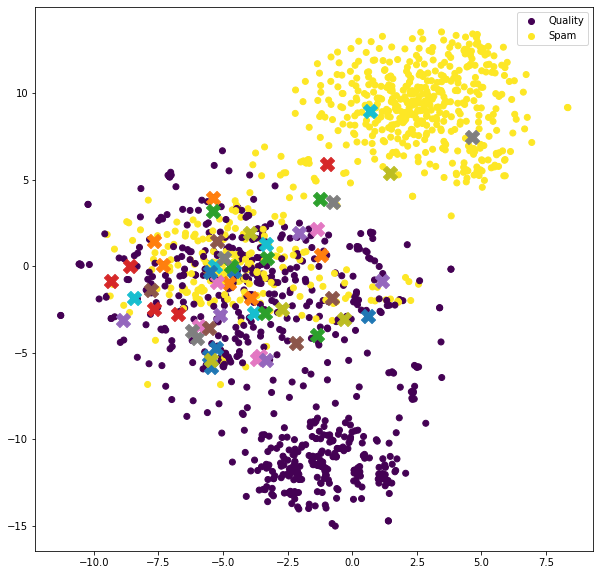

In [14]:
tsne_embeds = TSNE(random_state=42).fit_transform(x_test_vect)
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(tsne_embeds[:,0], tsne_embeds[:,1], label=mnb_fit.predict(x_test_vect), c=[0 if label == "Quality" else 1 for label in mnb_fit.predict(x_test_vect)], cmap='viridis')
for idx in false_negatives:
    ax.scatter(tsne_embeds[idx,0], tsne_embeds[idx,1], s=200, marker="X")
# for idx in false_positives:
#     ax.scatter(tsne_embeds[idx,0], tsne_embeds[idx,1], s=200, marker="^")
legend = ax.legend(*scatter.legend_elements())
legend.get_texts()[0].set_text("Quality")
legend.get_texts()[1].set_text("Spam")
plt.savefig("nb_tsne.png")

# Debug the NB, top 10 most/least frequent words, show fail cases

In [5]:
class_labels = mnb.classes_
feat_names = transformer.get_feature_names_out()


quality = sorted(zip(feat_names, mnb.feature_count_[0]), key=lambda x : x[1], reverse=True)
spam = sorted(zip(feat_names, mnb.feature_count_[1]), key=lambda x : x[1], reverse=True)

quality_d = dict(quality)
spam_d = dict(spam)

false_negatives = []
false_positives = []
correct = []
for input, (prediction, label) in enumerate(zip(mnb_fit.predict(x_train_vect), y_train)):
    if prediction != label:
        tweet = x_train.iloc[input,0]

        words = re.findall(r'(?u)\b\w\w+\b', tweet)

        if len(words) < 10: continue

        Qw = np.array([quality_d[word.lower()] for word in words])
        Sw = np.array([spam_d[word.lower()] for word in words])
        Q = Qw/(Qw+Sw)
        S = Sw/(Qw+Sw)

        zxc = pd.DataFrame(np.array([Qw, Sw, Q, S]), columns=words, index=['Quality', 'Spam', 'Quality %', 'Spam %'])
        display(zxc)
        # df = pd.DataFrame({'quality': quality_w, 'spam': spam_w}, columns=words)
        # display(df)

        Qp = np.prod(Q[Q>0])
        Sp = np.prod(S[S>0])
        a = Qp if prediction == "Quality" else Sp
        b = Qp if label == "Quality" else Sp

        print(f"\"{tweet}\"\n\tPred: {prediction:<10} ({a:.04})\n\tReal: {label:<10} ({b:.04})\n") 

        if prediction == "Quality":
            false_negatives.append(input)
        else:
            false_positives.append(input)
    else:
        correct.append(input)

,By,the,end,of,the,night,the,hashtag,ThingsMoreTrustedThanHillary,is,...,gay,followers,block,me,love,you,guys,https,co,eB4vWF6bjB
Quality,180.0,1504.000000,23.000,654.000000,1504.000000,36.000000,1504.000000,6.000000,0.0,618.000000,...,6.000000,3.0,3.000,414.000000,143.000000,913.000000,31.000000,587.000000,79.00000,0.0
Spam,180.0,1203.000000,17.000,765.000000,1203.000000,15.000000,1203.000000,8.000000,7.0,445.000000,...,11.000000,2.0,5.000,57.000000,26.000000,286.000000,4.000000,3734.000000,3921.00000,1.0
Quality %,0.5,0.555597,0.575,0.460888,0.555597,0.705882,0.555597,0.428571,0.0,0.581373,...,0.352941,0.6,0.375,0.878981,0.846154,0.761468,0.885714,0.135848,0.01975,0.0
Spam %,0.5,0.444403,0.425,0.539112,0.444403,0.294118,0.444403,0.571429,1.0,0.418627,...,0.647059,0.4,0.625,0.121019,0.153846,0.238532,0.114286,0.864152,0.98025,1.0


"By the end of the night, the hashtag #ThingsMoreTrustedThanHillary is gonna make my gay followers block me I love you guys! https://t.co/eB4vWF6bjB"
	Pred: Quality    (1.909e-07)
	Real: Spam       (3.791e-10)



,especially,when,Trump,hires,illegal,workers,and,loses,charity,money,he,supposedly,raised,for,veterans
Quality,5.000000,187.00000,28.000000,1.0,4.000000,8.000000,702.000000,1.0,5.000000,21.000000,142.000000,2.0,2.0,645.000000,2.000000
Spam,1.000000,75.00000,403.000000,1.0,13.000000,9.000000,464.000000,4.0,4.000000,26.000000,112.000000,0.0,3.0,552.000000,9.000000
Quality %,0.833333,0.71374,0.064965,0.5,0.235294,0.470588,0.602058,0.2,0.555556,0.446809,0.559055,1.0,0.4,0.538847,0.181818
Spam %,0.166667,0.28626,0.935035,0.5,0.764706,0.529412,0.397942,0.8,0.444444,0.553191,0.440945,0.0,0.6,0.461153,0.818182


"especially when Trump hires illegal workers and loses charity money he supposedly raised for veterans."
	Pred: Spam       (7.055e-05)
	Real: Quality    (1.401e-06)



,stand,for,freedom,of,expression,doing,what,you,believe,in,and,going,after,your,dreams
Quality,3.000000,645.000000,2.000000,654.000000,1.0,33.000000,180.000000,913.000000,18.0,703.000000,702.000000,58.000000,68.000000,313.00000,8.000000
Spam,20.000000,552.000000,13.000000,765.000000,1.0,16.000000,95.000000,286.000000,18.0,1002.000000,464.000000,24.000000,162.000000,92.00000,1.000000
Quality %,0.130435,0.538847,0.133333,0.460888,0.5,0.673469,0.654545,0.761468,0.5,0.412317,0.602058,0.707317,0.295652,0.77284,0.888889
Spam %,0.869565,0.461153,0.866667,0.539112,0.5,0.326531,0.345455,0.238532,0.5,0.587683,0.397942,0.292683,0.704348,0.22716,0.111111


"I stand for freedom of expression, doing what you believe in, and going after your dreams."
	Pred: Quality    (1.293e-05)
	Real: Spam       (1.534e-06)



,HuffingtonPost,seems,to,me,they,just,wanted,to,promote,their,new,shop,that,all
Quality,0.0,6.000000,1307.000000,414.000000,145.000000,193.000000,9.00,1307.000000,2.0,72.000000,170.000000,7.000000,346.000000,182.000000
Spam,1.0,8.000000,1203.000000,57.000000,106.000000,111.000000,11.00,1203.000000,2.0,74.000000,129.000000,5.000000,231.000000,118.000000
Quality %,0.0,0.428571,0.520717,0.878981,0.577689,0.634868,0.45,0.520717,0.5,0.493151,0.568562,0.583333,0.599653,0.606667
Spam %,1.0,0.571429,0.479283,0.121019,0.422311,0.365132,0.55,0.479283,0.5,0.506849,0.431438,0.416667,0.400347,0.393333


"'@HuffingtonPost seems to me they just wanted to promote their new shop, that`s all!'"
	Pred: Quality    (0.0005015)
	Real: Spam       (9.665e-06)



,Activists,take,fracking,fight,to,feds,homes,http,washex,am,1smwJSj,via,DCExaminer
Quality,1.00,56.000000,2.0,12.000000,1307.000000,1.000000,1.000000,1102.00000,1.0,53.000000,1.0,105.000000,1.000000
Spam,3.00,33.000000,2.0,29.000000,1203.000000,5.000000,13.000000,175.00000,0.0,11.000000,0.0,67.000000,2.000000
Quality %,0.25,0.629213,0.5,0.292683,0.520717,0.166667,0.071429,0.86296,1.0,0.828125,1.0,0.610465,0.333333
Spam %,0.75,0.370787,0.5,0.707317,0.479283,0.833333,0.928571,0.13704,0.0,0.171875,0.0,0.389535,0.666667


"Activists take fracking fight to feds' homes http://washex.am/1smwJSj  via @DCExaminer"
	Pred: Spam       (0.0002231)
	Real: Quality    (2.075e-05)



,We,had,fun,little,adventure,to,see,the,plazalights,from,the,sky,tonight,https,co,5BHMqvAtOu
Quality,234.000000,41.000000,32.000000,34.000000,4.0,1307.000000,70.000000,1504.000000,0.0,190.000000,1504.000000,11.000000,25.000000,587.000000,79.00000,0.0
Spam,139.000000,27.000000,5.000000,17.000000,1.0,1203.000000,36.000000,1203.000000,1.0,172.000000,1203.000000,1.000000,8.000000,3734.000000,3921.00000,1.0
Quality %,0.627346,0.602941,0.864865,0.666667,0.8,0.520717,0.660377,0.555597,0.0,0.524862,0.555597,0.916667,0.757576,0.135848,0.01975,0.0
Spam %,0.372654,0.397059,0.135135,0.333333,0.2,0.479283,0.339623,0.444403,1.0,0.475138,0.444403,0.083333,0.242424,0.864152,0.98025,1.0


"We had a fun little adventure to see the #plazalights from the sky tonight. https://t.co/5BHMqvAtOu"
	Pred: Quality    (1.811e-05)
	Real: Spam       (3.484e-07)



,IHaveNoIdeaAbout,Salem,but,knows,witches,burned,on,my,birthday,PowerpuffTag
Quality,0.0,0.0,169.000000,13.000000,0.0,1.00,480.000000,379.000000,72.000000,0.0
Spam,1.0,1.0,79.000000,6.000000,1.0,3.00,386.000000,98.000000,4.000000,1.0
Quality %,0.0,0.0,0.681452,0.684211,0.0,0.25,0.554273,0.794549,0.947368,0.0
Spam %,1.0,1.0,0.318548,0.315789,1.0,0.75,0.445727,0.205451,0.052632,1.0


"#IHaveNoIdeaAbout Salem, but I knows witches burned on my birthday. @PowerpuffTag"
	Pred: Quality    (0.04863)
	Real: Spam       (0.0003636)



,Wake,up,each,morning,with,smile,in,your,heart,It,new,day,and,you,re,alive,Christian,prolife,PraytoEndAbortion
Quality,13.000000,161.000000,7.0,46.000000,303.000000,6.0,703.000000,313.00000,26.000000,521.000000,170.000000,119.000000,702.000000,913.000000,104.000000,5.00,1.000000,0.0,0.0
Spam,2.000000,110.000000,7.0,12.000000,277.000000,4.0,1002.000000,92.00000,11.000000,225.000000,129.000000,71.000000,464.000000,286.000000,44.000000,15.00,10.000000,1.0,1.0
Quality %,0.866667,0.594096,0.5,0.793103,0.522414,0.6,0.412317,0.77284,0.702703,0.698391,0.568562,0.626316,0.602058,0.761468,0.702703,0.25,0.090909,0.0,0.0
Spam %,0.133333,0.405904,0.5,0.206897,0.477586,0.4,0.587683,0.22716,0.297297,0.301609,0.431438,0.373684,0.397942,0.238532,0.297297,0.75,0.909091,1.0,1.0


"Wake up each morning with a smile in your heart. It's a new day and you're alive. #Christian #prolife #PraytoEndAbortion"
	Pred: Quality    (2.609e-05)
	Real: Spam       (3.972e-08)



,DontTellAnyoneBut,if,something,ever,happens,to,me,need,you,to,clean,my,browser,history,and,delete,some,folders,named,projects
Quality,0.0,180.000000,31.000000,39.000000,10.000000,1307.000000,414.000000,80.000000,913.000000,1307.000000,8.000000,379.000000,0.0,9.000000,702.000000,0.0,89.000000,0.0,6.000000,2.000000
Spam,7.0,89.000000,15.000000,25.000000,2.000000,1203.000000,57.000000,36.000000,286.000000,1203.000000,5.000000,98.000000,2.0,22.000000,464.000000,1.0,37.000000,1.0,7.000000,5.000000
Quality %,0.0,0.669145,0.673913,0.609375,0.833333,0.520717,0.878981,0.689655,0.761468,0.520717,0.615385,0.794549,0.0,0.290323,0.602058,0.0,0.706349,0.0,0.461538,0.285714
Spam %,1.0,0.330855,0.326087,0.390625,0.166667,0.479283,0.121019,0.310345,0.238532,0.479283,0.384615,0.205451,1.0,0.709677,0.397942,1.0,0.293651,1.0,0.538462,0.714286


"#DontTellAnyoneBut if something ever happens to me I need you to clean my browser history and delete some folders named ''projects''"
	Pred: Quality    (0.0002282)
	Real: Spam       (3.643e-08)



,nobody,came,at,you,You,came,at,me,wrong,and,...,didn,like,my,response,when,did,someothaship,https,co,hV41Vaa4aN
Quality,3.0,12.0,277.000000,913.000000,913.000000,12.0,277.000000,414.000000,12.000000,702.000000,...,22.000000,184.000000,379.000000,2.000000,187.00000,41.000000,0.0,587.000000,79.00000,0.0
Spam,3.0,8.0,259.000000,286.000000,286.000000,8.0,259.000000,57.000000,17.000000,464.000000,...,19.000000,75.000000,98.000000,4.000000,75.00000,45.000000,1.0,3734.000000,3921.00000,1.0
Quality %,0.5,0.6,0.516791,0.761468,0.761468,0.6,0.516791,0.878981,0.413793,0.602058,...,0.536585,0.710425,0.794549,0.333333,0.71374,0.476744,0.0,0.135848,0.01975,0.0
Spam %,0.5,0.4,0.483209,0.238532,0.238532,0.4,0.483209,0.121019,0.586207,0.397942,...,0.463415,0.289575,0.205451,0.666667,0.28626,0.523256,1.0,0.864152,0.98025,1.0


"2 nobody came at you. You came at me wrong and you didn't like my response when u did. @someothaship https://t.co/hV41Vaa4aN"
	Pred: Quality    (4.284e-07)
	Real: Spam       (1.669e-08)



,MyBestHolidayMemory,Would,be,December,25,2007,or,2008,when,have,some,of,the,best,gifts,No,pictures,sorry
Quality,0.0,67.000,369.000000,0.0,9.0,0.0,80.000000,2.0,187.00000,229.000000,89.000000,654.000000,1504.000000,61.000000,2.0,134.000000,8.000000,21.000000
Spam,1.0,58.000,192.000000,4.0,6.0,2.0,66.000000,3.0,75.00000,111.000000,37.000000,765.000000,1203.000000,28.000000,3.0,108.000000,9.000000,5.000000
Quality %,0.0,0.536,0.657754,0.0,0.6,0.0,0.547945,0.4,0.71374,0.673529,0.706349,0.460888,0.555597,0.685393,0.4,0.553719,0.470588,0.807692
Spam %,1.0,0.464,0.342246,1.0,0.4,1.0,0.452055,0.6,0.28626,0.326471,0.293651,0.539112,0.444403,0.314607,0.6,0.446281,0.529412,0.192308


"#MyBestHolidayMemory Would be December 25 2007 or 2008 when I have some of the best gifts. ( No pictures sorry)"
	Pred: Quality    (0.0002326)
	Real: Spam       (9.716e-07)



,Every,girl,deserves,guy,who,can,make,her,forget,that,her,heart,was,ever,broken
Quality,36.00000,54.00000,3.0,18.0,101.000000,224.000000,70.000,85.000000,13.000000,346.000000,85.000000,26.000000,157.000000,39.000000,3.000000
Spam,22.00000,20.00000,3.0,12.0,138.000000,88.000000,42.000,72.000000,5.000000,231.000000,72.000000,11.000000,134.000000,25.000000,8.000000
Quality %,0.62069,0.72973,0.5,0.6,0.422594,0.717949,0.625,0.541401,0.722222,0.599653,0.541401,0.702703,0.539519,0.609375,0.272727
Spam %,0.37931,0.27027,0.5,0.4,0.577406,0.282051,0.375,0.458599,0.277778,0.400347,0.458599,0.297297,0.460481,0.390625,0.727273


"Every girl deserves a guy who can make her forget that her heart was ever broken."
	Pred: Quality    (0.0002061)
	Real: Spam       (1.139e-06)



,97,year,old,veteran,meets,girl,who,wrote,thank,you,letter
Quality,0.0,54.000000,34.000000,1.000000,2.000000,54.00000,101.000000,2.0,72.00000,913.000000,6.000000
Spam,2.0,60.000000,42.000000,2.000000,4.000000,20.00000,138.000000,2.0,11.00000,286.000000,3.000000
Quality %,0.0,0.473684,0.447368,0.333333,0.333333,0.72973,0.422594,0.5,0.86747,0.761468,0.666667
Spam %,1.0,0.526316,0.552632,0.666667,0.666667,0.27027,0.577406,0.5,0.13253,0.238532,0.333333


"97-year-old veteran meets girl who wrote thank you letter"
	Pred: Quality    (0.001599)
	Real: Spam       (0.0001063)



,To,all,my,freedom,fighters,in,Gaza,advise,you,to,download,periscope,so,we,can,see,was,happening,Gazaunderattack
Quality,1307.000000,182.000000,379.000000,2.000000,0.0,703.000000,1.0,0.0,913.000000,1307.000000,7.000000,8.0,274.00000,234.000000,224.000000,70.000000,157.000000,8.000000,0.0
Spam,1203.000000,118.000000,98.000000,13.000000,4.0,1002.000000,1.0,2.0,286.000000,1203.000000,4.000000,2.0,61.00000,139.000000,88.000000,36.000000,134.000000,7.000000,1.0
Quality %,0.520717,0.606667,0.794549,0.133333,0.0,0.412317,0.5,0.0,0.761468,0.520717,0.636364,0.8,0.81791,0.627346,0.717949,0.660377,0.539519,0.533333,0.0
Spam %,0.479283,0.393333,0.205451,0.866667,1.0,0.587683,0.5,1.0,0.238532,0.479283,0.363636,0.2,0.18209,0.372654,0.282051,0.339623,0.460481,0.466667,1.0


"To  all my freedom fighters in #Gaza i advise you to download  periscope so we can see was happening  #Gazaunderattack"
	Pred: Quality    (9.749e-05)
	Real: Spam       (1.146e-07)



,Official,WHITE,PAPER,main,crimes,against,human,rights,in,Ukraine,http,lnkd,in,dHpfFVn
Quality,19.00000,15.000000,21.00,3.000,2.000000,33.000000,12.000000,10.0000,703.000000,3.000000,1102.00000,5.0,703.000000,1.0
Spam,13.00000,70.000000,4.00,5.000,10.000000,71.000000,9.000000,22.0000,1002.000000,6.000000,175.00000,0.0,1002.000000,0.0
Quality %,0.59375,0.176471,0.84,0.375,0.166667,0.317308,0.571429,0.3125,0.412317,0.333333,0.86296,1.0,0.412317,1.0
Spam %,0.40625,0.823529,0.16,0.625,0.833333,0.682692,0.428571,0.6875,0.587683,0.666667,0.13704,0.0,0.587683,0.0


"Official WHITE PAPER - main crimes against human rights in Ukraine k http://lnkd.in/dHpfFVn"
	Pred: Spam       (0.000177)
	Real: Quality    (1.524e-05)



,IslamKills,if,you,had,100,grapes,and,knew,were,deadly,would,you,still,eat,some
Quality,0.0,180.000000,913.000000,41.000000,12.0,0.0,702.000000,7.000000,34.000000,2.000000,67.000,913.000000,59.000000,14.000000,89.000000
Spam,8.0,89.000000,286.000000,27.000000,18.0,2.0,464.000000,4.000000,27.000000,10.000000,58.000,286.000000,33.000000,3.000000,37.000000
Quality %,0.0,0.669145,0.761468,0.602941,0.4,0.0,0.602058,0.636364,0.557377,0.166667,0.536,0.761468,0.641304,0.823529,0.706349
Spam %,1.0,0.330855,0.238532,0.397059,0.6,1.0,0.397942,0.363636,0.442623,0.833333,0.464,0.238532,0.358696,0.176471,0.293651


"#IslamKills if you had 100 grapes and knew 2 were deadly, would you still eat some?"
	Pred: Quality    (0.0006659)
	Real: Spam       (2.065e-06)



,IfIHadABodyDouble,then,dating,would,be,less,awkward,cause,tired,of,takin,myself,to,dinner,and,talking,to,myself
Quality,0.0,47.000000,6.000000,67.000,369.000000,9.0,3.0,11.00000,8.000000,654.000000,0.0,19.000000,1307.000000,3.0,702.000000,10.000000,1307.000000,19.000000
Spam,1.0,26.000000,3.000000,58.000,192.000000,6.0,3.0,10.00000,4.000000,765.000000,1.0,3.000000,1203.000000,3.0,464.000000,8.000000,1203.000000,3.000000
Quality %,0.0,0.643836,0.666667,0.536,0.657754,0.6,0.5,0.52381,0.666667,0.460888,0.0,0.863636,0.520717,0.5,0.602058,0.555556,0.520717,0.863636
Spam %,1.0,0.356164,0.333333,0.464,0.342246,0.4,0.5,0.47619,0.333333,0.539112,1.0,0.136364,0.479283,0.5,0.397942,0.444444,0.479283,0.136364


"#IfIHadABodyDouble then dating would be less awkward cause I'm tired of takin myself to dinner and talking to myself."
	Pred: Quality    (0.0002471)
	Real: Spam       (1.219e-07)



,They,May,Take,our,Lives,BUT,THEY,LL,NEVER,TAKE,AWAY,OUR,PIZZA,OneWordOffMovieQuotes,midnight
Quality,145.000000,70.000,56.000000,114.000000,8.00,169.000000,145.000000,60.000000,62.000000,56.000000,18.00,114.000000,2.000000,0.0,5.000000
Spam,106.000000,42.000,33.000000,93.000000,17.00,79.000000,106.000000,17.000000,36.000000,33.000000,7.00,93.000000,7.000000,1.0,24.000000
Quality %,0.577689,0.625,0.629213,0.550725,0.32,0.681452,0.577689,0.779221,0.632653,0.629213,0.72,0.550725,0.222222,0.0,0.172414
Spam %,0.422311,0.375,0.370787,0.449275,0.68,0.318548,0.422311,0.220779,0.367347,0.370787,0.28,0.449275,0.777778,1.0,0.827586


"They May Take our Lives, BUT THEY'LL NEVER TAKE AWAY OUR PIZZA! #OneWordOffMovieQuotes @midnight"
	Pred: Quality    (7.427e-05)
	Real: Spam       (5.876e-06)



,It,because,we,re,from,the,South,you,see,bee,you,don,move,like,its,Rex,LukeEdgemon,happy4th
Quality,521.000000,37.000000,234.000000,104.000000,190.000000,1504.000000,14.000000,913.000000,70.000000,2.0,913.000000,133.0,10.000000,184.000000,58.000000,1.0,0.0,0.0
Spam,225.000000,32.000000,139.000000,44.000000,172.000000,1203.000000,39.000000,286.000000,36.000000,2.0,286.000000,57.0,13.000000,75.000000,38.000000,1.0,1.0,1.0
Quality %,0.698391,0.536232,0.627346,0.702703,0.524862,0.555597,0.264151,0.761468,0.660377,0.5,0.761468,0.7,0.434783,0.710425,0.604167,0.5,0.0,0.0
Spam %,0.301609,0.463768,0.372654,0.297297,0.475138,0.444403,0.735849,0.238532,0.339623,0.5,0.238532,0.3,0.565217,0.289575,0.395833,0.5,1.0,1.0


""It's because we're from the South you see a bee you don't move like its a T-Rex"   @LukeEdgemon   #happy4th"
	Pred: Quality    (0.000159)
	Real: Spam       (2.261e-07)



,FeministaJones,Especially,if,the,journey,isn,physically,safe,one,for,any,of,reasons
Quality,0.0,5.000000,180.000000,1504.000000,9.0,20.000000,0.0,11.00,120.000000,645.000000,41.000000,654.000000,3.000000
Spam,2.0,1.000000,89.000000,1203.000000,1.0,11.000000,2.0,14.00,97.000000,552.000000,22.000000,765.000000,6.000000
Quality %,0.0,0.833333,0.669145,0.555597,0.9,0.645161,0.0,0.44,0.552995,0.538847,0.650794,0.460888,0.333333
Spam %,1.0,0.166667,0.330855,0.444403,0.1,0.354839,1.0,0.56,0.447005,0.461153,0.349206,0.539112,0.666667


"'@FeministaJones Especially if the journey isn't a physically safe one, for any # of reasons.'"
	Pred: Quality    (0.002358)
	Real: Spam       (1.26e-05)



,ugh,the,foke,more,think,about,having,to,apply,for,unis,this,year,the,more,scared,get
Quality,5.000000,1504.000000,0.0,117.000000,75.000000,128.000000,19.000000,1307.000000,3.0,645.000000,0.0,395.000000,54.000000,1504.000000,117.000000,11.000000,144.000000
Spam,1.000000,1203.000000,9.0,101.000000,26.000000,118.000000,12.000000,1203.000000,2.0,552.000000,1.0,210.000000,60.000000,1203.000000,101.000000,7.000000,76.000000
Quality %,0.833333,0.555597,0.0,0.536697,0.742574,0.520325,0.612903,0.520717,0.6,0.538847,0.0,0.652893,0.473684,0.555597,0.536697,0.611111,0.654545
Spam %,0.166667,0.444403,1.0,0.463303,0.257426,0.479675,0.387097,0.479283,0.4,0.461153,1.0,0.347107,0.526316,0.444403,0.463303,0.388889,0.345455


"ugh the foke more i think about having to apply for unis this year the more scared i get"
	Pred: Quality    (0.0003654)
	Real: Spam       (7.328e-07)



,Michelle,Obama,This,belief,that,you,can,do,anything,you,...,to,woman,It,is,cruel,It,is,frightening,It,hurts
Quality,3.000000,10.000000,395.000000,0.0,346.000000,913.000000,224.000000,166.000000,16.000000,913.000000,...,1307.000000,15.000000,521.000000,618.000000,1.0,521.000000,618.000000,0.0,521.000000,1.000000
Spam,6.000000,112.000000,210.000000,1.0,231.000000,286.000000,88.000000,73.000000,13.000000,286.000000,...,1203.000000,58.000000,225.000000,445.000000,1.0,225.000000,445.000000,1.0,225.000000,2.000000
Quality %,0.333333,0.081967,0.652893,0.0,0.599653,0.761468,0.717949,0.694561,0.551724,0.761468,...,0.520717,0.205479,0.698391,0.581373,0.5,0.698391,0.581373,0.0,0.698391,0.333333
Spam %,0.666667,0.918033,0.347107,1.0,0.400347,0.238532,0.282051,0.305439,0.448276,0.238532,...,0.479283,0.794521,0.301609,0.418627,0.5,0.301609,0.418627,1.0,0.301609,0.666667


"Michelle Obama: "This belief that you can do anything you want to a woman? It is cruel. It is frightening. It hurts.""
	Pred: Quality    (2.453e-06)
	Real: Spam       (3.422e-08)



,Can,you,tell,us,the,truth,for,once,Laurel,asking,...,million,dollar,question,on,this,show,of,lies,LMAO,HTGAWM
Quality,224.000000,913.000000,25.000000,87.000000,1504.000000,10.000000,645.000000,15.000000,0.0,4.000000,...,13.000000,8.000000,9.000000,480.000000,395.000000,47.000000,654.000000,3.000000,18.000000,0.0
Spam,88.000000,286.000000,21.000000,83.000000,1203.000000,18.000000,552.000000,6.000000,1.0,5.000000,...,34.000000,3.000000,8.000000,386.000000,210.000000,29.000000,765.000000,11.000000,1.000000,1.0
Quality %,0.717949,0.761468,0.543478,0.511765,0.555597,0.357143,0.538847,0.714286,0.0,0.444444,...,0.276596,0.727273,0.529412,0.554273,0.652893,0.618421,0.460888,0.214286,0.947368,0.0
Spam %,0.282051,0.238532,0.456522,0.488235,0.444403,0.642857,0.461153,0.285714,1.0,0.555556,...,0.723404,0.272727,0.470588,0.445727,0.347107,0.381579,0.539112,0.785714,0.052632,1.0


""Can you tell us the truth for once?" Laurel asking the million dollar question on this show of lies LMAO. #HTGAWM"
	Pred: Quality    (6.395e-06)
	Real: Spam       (1.703e-08)



,Dear,Angelina,Jolie,still,hoping,that,you,will,adopt,me,TellACelebWhyYouLikeThem
Quality,8.0,1.0,1.0,59.000000,2.0,346.000000,913.000000,149.000000,0.0,414.000000,0.0
Spam,2.0,1.0,1.0,33.000000,3.0,231.000000,286.000000,132.000000,3.0,57.000000,1.0
Quality %,0.8,0.5,0.5,0.641304,0.4,0.599653,0.761468,0.530249,0.0,0.878981,0.0
Spam %,0.2,0.5,0.5,0.358696,0.6,0.400347,0.238532,0.469751,1.0,0.121019,1.0


"Dear Angelina Jolie,  I'm still hoping that you will adopt me.   #TellACelebWhyYouLikeThem"
	Pred: Quality    (0.01092)
	Real: Spam       (5.842e-05)



,CharlesBukowski,Barfly,Anybody,can,be,non,drunk,book,bookquotes,quote,quotes,drunk
Quality,0.0,0.0,1.0,224.000000,369.000000,4.0,7.000000,13.00,0.0,7.000000,4.000000,7.000000
Spam,1.0,1.0,1.0,88.000000,192.000000,6.0,4.000000,7.00,1.0,5.000000,2.000000,4.000000
Quality %,0.0,0.0,0.5,0.717949,0.657754,0.4,0.636364,0.65,0.0,0.583333,0.666667,0.636364
Spam %,1.0,1.0,0.5,0.282051,0.342246,0.6,0.363636,0.35,1.0,0.416667,0.333333,0.363636


"#CharlesBukowski #Barfly: Anybody can be a non-drunk.. #book #bookquotes #quote #quotes #drunk"
	Pred: Quality    (0.009668)
	Real: Spam       (0.0001861)



,That,moment,on,holiday,early,evening,when,people,break,down,and,start,fighting,on,Twitter,again
Quality,346.000000,15.000000,480.000000,2.0,9.000000,7.000000,187.00000,91.000000,5.0,37.00000,702.000000,27.000000,6.000000,480.000000,1835.000000,32.000000
Spam,231.000000,6.000000,386.000000,8.0,10.000000,5.000000,75.00000,104.000000,20.0,52.00000,464.000000,16.000000,12.000000,386.000000,15.000000,39.000000
Quality %,0.599653,0.714286,0.554273,0.2,0.473684,0.583333,0.71374,0.466667,0.2,0.41573,0.602058,0.627907,0.333333,0.554273,0.991892,0.450704
Spam %,0.400347,0.285714,0.445727,0.8,0.526316,0.416667,0.28626,0.533333,0.8,0.58427,0.397942,0.372093,0.666667,0.445727,0.008108,0.549296


"That moment on a holiday, early evening, when people break down and start fighting on Twitter again."
	Pred: Quality    (1.135e-05)
	Real: Spam       (1.251e-07)



,IfICouldntLie,would,never,be,able,to,find,my,safe,place
Quality,0.0,67.000,62.000000,369.000000,8.0,1307.000000,33.000000,379.000000,11.00,17.00000
Spam,1.0,58.000,36.000000,192.000000,8.0,1203.000000,28.000000,98.000000,14.00,10.00000
Quality %,0.0,0.536,0.632653,0.657754,0.5,0.520717,0.540984,0.794549,0.44,0.62963
Spam %,1.0,0.464,0.367347,0.342246,0.5,0.479283,0.459016,0.205451,0.56,0.37037


"#IfICouldntLie I would never be able to find my "safe place"..."
	Pred: Quality    (0.006915)
	Real: Spam       (0.0002734)



,Imagining,her,daintily,dabbing,it,behind,her,ears,might,send,me,on,up,to,glory,today
Quality,1.00,85.000000,0.0,0.0,521.000000,11.000000,85.000000,0.0,13.000000,11.000000,414.000000,480.000000,161.000000,1307.000000,3.00,97.000000
Spam,3.00,72.000000,1.0,1.0,225.000000,16.000000,72.000000,1.0,5.000000,7.000000,57.000000,386.000000,110.000000,1203.000000,1.00,46.000000
Quality %,0.25,0.541401,0.0,0.0,0.698391,0.407407,0.541401,0.0,0.722222,0.611111,0.878981,0.554273,0.594096,0.520717,0.75,0.678322
Spam %,0.75,0.458599,1.0,1.0,0.301609,0.592593,0.458599,1.0,0.277778,0.388889,0.121019,0.445727,0.405904,0.479283,0.25,0.321678


"Imagining her daintily dabbing it behind her ears might send me on up to glory today."
	Pred: Quality    (0.0007056)
	Real: Spam       (2.57e-06)



,Amazing,that,Crooked,Hillary,can,do,hit,ad,on,me,...,husband,was,the,WORST,abuser,of,woman,in,political,history
Quality,21.000000,346.000000,5.000,13.000000,224.000000,166.000000,16.000000,10.000000,480.000000,414.000000,...,4.000000,157.000000,1504.000000,6.000000,1.0,654.000000,15.000000,703.000000,3.000000,9.000000
Spam,6.000000,231.000000,3.000,76.000000,88.000000,73.000000,22.000000,7.000000,386.000000,57.000000,...,5.000000,134.000000,1203.000000,13.000000,0.0,765.000000,58.000000,1002.000000,20.000000,22.000000
Quality %,0.777778,0.599653,0.625,0.146067,0.717949,0.694561,0.421053,0.588235,0.554273,0.878981,...,0.444444,0.539519,0.555597,0.315789,1.0,0.460888,0.205479,0.412317,0.130435,0.290323
Spam %,0.222222,0.400347,0.375,0.853933,0.282051,0.305439,0.578947,0.411765,0.445727,0.121019,...,0.555556,0.460481,0.444403,0.684211,0.0,0.539112,0.794521,0.587683,0.869565,0.709677


"Amazing that Crooked Hillary can do a hit ad on me concerning women when her husband was the WORST abuser of woman in U.S. political history"
	Pred: Spam       (1.42e-08)
	Real: Quality    (1.333e-08)



,IWishIHadTwo,to,make,thing,go,right,It,takes,two,to,make,it,outta,sight,Rob,Base
Quality,0.0,1307.000000,70.000,35.000000,81.000000,46.000000,521.000000,11.00000,34.000000,1307.000000,70.000,521.000000,3.0,1.00,0.0,7.0
Spam,1.0,1203.000000,42.000,14.000000,55.000000,44.000000,225.000000,10.00000,41.000000,1203.000000,42.000,225.000000,2.0,3.00,2.0,7.0
Quality %,0.0,0.520717,0.625,0.714286,0.595588,0.511111,0.698391,0.52381,0.453333,0.520717,0.625,0.698391,0.6,0.25,0.0,0.5
Spam %,1.0,0.479283,0.375,0.285714,0.404412,0.488889,0.301609,0.47619,0.546667,0.479283,0.375,0.301609,0.4,0.75,1.0,0.5


"#IWishIHadTwo to make a thing go right. It takes two to make it outta sight. --Rob Base"
	Pred: Quality    (0.0002001)
	Real: Spam       (6.482e-06)



,ShareNews,Court,orders,schools,to,desegregate,http,cnn,it,1smL1lU
Quality,1.0,7.000000,3.0,7.000000,1307.000000,1.0,1102.00000,7.000000,521.000000,1.0
Spam,0.0,46.000000,7.0,10.000000,1203.000000,0.0,175.00000,38.000000,225.000000,0.0
Quality %,1.0,0.132075,0.3,0.411765,0.520717,1.0,0.86296,0.155556,0.698391,1.0
Spam %,0.0,0.867925,0.7,0.588235,0.479283,0.0,0.13704,0.844444,0.301609,0.0


"#ShareNews Court orders schools to desegregate http://cnn.it/1smL1lU"
	Pred: Spam       (0.005978)
	Real: Quality    (0.0007965)



,Ive,found,that,luck,is,quite,predictable,If,you,want,...,take,more,chances,Be,more,active,Show,up,more,often
Quality,3.0,16.000000,346.000000,10.000000,618.000000,2.000000,1.0,180.000000,913.000000,77.0,...,56.000000,117.000000,3.0,369.000000,117.000000,1.0,47.000000,161.000000,117.000000,4.000000
Spam,3.0,30.000000,231.000000,3.000000,445.000000,4.000000,1.0,89.000000,286.000000,33.0,...,33.000000,101.000000,3.0,192.000000,101.000000,4.0,29.000000,110.000000,101.000000,2.000000
Quality %,0.5,0.347826,0.599653,0.769231,0.581373,0.333333,0.5,0.669145,0.761468,0.7,...,0.629213,0.536697,0.5,0.657754,0.536697,0.2,0.618421,0.594096,0.536697,0.666667
Spam %,0.5,0.652174,0.400347,0.230769,0.418627,0.666667,0.5,0.330855,0.238532,0.3,...,0.370787,0.463303,0.5,0.342246,0.463303,0.8,0.381579,0.405904,0.463303,0.333333


"Ive found that luck is quite predictable. If you want more luck, take more chances. Be more active. Show up more often."
	Pred: Quality    (1.794e-06)
	Real: Spam       (2.773e-09)



,DadSongs,midnight,Chevy,Van,How,much,That,alright,by,me
Quality,0.0,5.000000,1.0,14.000000,157.000000,62.000000,346.000000,3.00,180.0,414.000000
Spam,1.0,24.000000,1.0,3.000000,95.000000,21.000000,231.000000,1.00,180.0,57.000000
Quality %,0.0,0.172414,0.5,0.823529,0.623016,0.746988,0.599653,0.75,0.5,0.878981
Spam %,1.0,0.827586,0.5,0.176471,0.376984,0.253012,0.400347,0.25,0.5,0.121019


"#DadSongs @midnight   Chevy Van?  How much?  That's alright by me!"
	Pred: Quality    (0.00653)
	Real: Spam       (4.218e-05)



,And,pregnant,woman,at,that,hope,she,and,her,baby,are,ok,That,really,horrendous
Quality,702.000000,1.0,15.000000,277.000000,346.000000,34.000000,84.000000,702.000000,85.000000,23.000000,224.000000,22.000000,346.000000,66.000000,1.0
Spam,464.000000,1.0,58.000000,259.000000,231.000000,18.000000,52.000000,464.000000,72.000000,11.000000,196.000000,7.000000,231.000000,18.000000,1.0
Quality %,0.602058,0.5,0.205479,0.516791,0.599653,0.653846,0.617647,0.602058,0.541401,0.676471,0.533333,0.758621,0.599653,0.785714,0.5
Spam %,0.397942,0.5,0.794521,0.483209,0.400347,0.346154,0.382353,0.397942,0.458599,0.323529,0.466667,0.241379,0.400347,0.214286,0.5


"And a pregnant woman at that. I hope she and her baby are ok. That's really horrendous."
	Pred: Quality    (0.0001627)
	Real: Spam       (1.155e-06)



,IfIWereYourMom,you,won,need,GPS,was,able,to,hit,your,Dad,girlfriend,once,based,on,my,instinct,of,navigation
Quality,0.0,913.000000,22.000000,80.000000,0.0,157.000000,8.0,1307.000000,16.000000,313.00000,10.000000,3.00,15.000000,6.000000,480.000000,379.000000,0.0,654.000000,0.0
Spam,3.0,286.000000,26.000000,36.000000,1.0,134.000000,8.0,1203.000000,22.000000,92.00000,4.000000,1.00,6.000000,5.000000,386.000000,98.000000,1.0,765.000000,1.0
Quality %,0.0,0.761468,0.458333,0.689655,0.0,0.539519,0.5,0.520717,0.421053,0.77284,0.714286,0.75,0.714286,0.545455,0.554273,0.794549,0.0,0.460888,0.0
Spam %,1.0,0.238532,0.541667,0.310345,1.0,0.460481,0.5,0.479283,0.578947,0.22716,0.285714,0.25,0.285714,0.454545,0.445727,0.205451,1.0,0.539112,1.0


"#IfIWereYourMom you won't need a GPS. I was able to hit your Dad's girlfriend once based on my instinct of navigation."
	Pred: Quality    (0.0004661)
	Real: Spam       (2.665e-07)



,The,more,you,care,the,more,you,have,to,lose
Quality,1504.000000,117.000000,913.000000,16.000000,1504.000000,117.000000,913.000000,229.000000,1307.000000,5.00
Spam,1203.000000,101.000000,286.000000,21.000000,1203.000000,101.000000,286.000000,111.000000,1203.000000,15.00
Quality %,0.555597,0.536697,0.761468,0.432432,0.555597,0.536697,0.761468,0.673529,0.520717,0.25
Spam %,0.444403,0.463303,0.238532,0.567568,0.444403,0.463303,0.238532,0.326471,0.479283,0.75


"The more you care, the more you have to lose."
	Pred: Quality    (0.001955)
	Real: Spam       (0.0001607)



,hugoaf,publicfunlovers,tempete75,Cum,When,drive,in,highway,publicfunlovers,OVER,35,000,https,tmblr,co,Zyppwq26bD9e_
Quality,1.0,2.0,1.0,2.0,187.00000,7.000000,703.000000,1.0,2.0,64.000000,3.000,19.000000,587.000000,9.0,79.00000,1.0
Spam,0.0,0.0,0.0,0.0,75.00000,5.000000,1002.000000,4.0,0.0,106.000000,5.000,20.000000,3734.000000,0.0,3921.00000,0.0
Quality %,1.0,1.0,1.0,1.0,0.71374,0.583333,0.412317,0.2,1.0,0.376471,0.375,0.487179,0.135848,1.0,0.01975,1.0
Spam %,0.0,0.0,0.0,0.0,0.28626,0.416667,0.587683,0.8,0.0,0.623529,0.625,0.512821,0.864152,0.0,0.98025,0.0


"hugoaf: publicfunlovers: tempete75: Cum When i drive in highway @publicfunlovers  OVER 35.000... https://tmblr.co/Zyppwq26bD9e_"
	Pred: Spam       (0.009493)
	Real: Quality    (6.336e-06)



,Trump,is,gonna,whoop,them,Beast,Savage,Like,dry,bones,...,the,valley,Thats,why,God,allowed,it,Its,that,time
Quality,28.000000,618.000000,36.0,2.000000,52.000000,4.000000,1.000000,184.000000,2.000000,5.000000,...,1504.000000,0.0,7.000000,100.000000,42.00000,2.000000,521.000000,58.000000,346.000000,96.000000
Spam,403.000000,445.000000,4.0,1.000000,50.000000,2.000000,2.000000,75.000000,1.000000,1.000000,...,1203.000000,6.0,2.000000,62.000000,22.00000,5.000000,225.000000,38.000000,231.000000,45.000000
Quality %,0.064965,0.581373,0.9,0.666667,0.509804,0.666667,0.333333,0.710425,0.666667,0.833333,...,0.555597,0.0,0.777778,0.617284,0.65625,0.285714,0.698391,0.604167,0.599653,0.680851
Spam %,0.935035,0.418627,0.1,0.333333,0.490196,0.333333,0.666667,0.289575,0.333333,0.166667,...,0.444403,1.0,0.222222,0.382716,0.34375,0.714286,0.301609,0.395833,0.400347,0.319149


"#Trump is gonna whoop them #Beast #Savage. Like dry bones in the valley. Thats why God allowed it. Its that time."
	Pred: Quality    (3.6e-06)
	Real: Spam       (1.902e-09)



,BeingBlackIs,being,told,you,talk,like,white,person,when,you,re,articulate
Quality,0.0,43.000000,17.000000,913.000000,32.000000,184.000000,15.000000,28.000000,187.00000,913.000000,104.000000,0.0
Spam,1.0,47.000000,14.000000,286.000000,14.000000,75.000000,70.000000,17.000000,75.00000,286.000000,44.000000,1.0
Quality %,0.0,0.477778,0.548387,0.761468,0.695652,0.710425,0.176471,0.622222,0.71374,0.761468,0.702703,0.0
Spam %,1.0,0.522222,0.451613,0.238532,0.304348,0.289575,0.823529,0.377778,0.28626,0.238532,0.297297,1.0


"#BeingBlackIs being told you "talk like a white person" when you're articulate. "
	Pred: Quality    (0.004135)
	Real: Spam       (3.131e-05)



,It,laughable,when,35,39,of,Bernie,voters,WV,are,...,Trump,OVER,Bernie,in,GE,HRC,wins,with,actual,Democrats
Quality,521.000000,2.0,187.00000,3.000,2.0,654.000000,15.000000,5.00,1.0,224.000000,...,28.000000,64.000000,15.000000,703.000000,1.0,1.00,5.000000,303.000000,7.000000,2.0000
Spam,225.000000,0.0,75.00000,5.000,2.0,765.000000,12.000000,15.00,0.0,196.000000,...,403.000000,106.000000,12.000000,1002.000000,0.0,3.00,13.000000,277.000000,2.000000,30.0000
Quality %,0.698391,1.0,0.71374,0.375,0.5,0.460888,0.555556,0.25,1.0,0.533333,...,0.064965,0.376471,0.555556,0.412317,1.0,0.25,0.277778,0.522414,0.777778,0.0625
Spam %,0.301609,0.0,0.28626,0.625,0.5,0.539112,0.444444,0.75,0.0,0.466667,...,0.935035,0.623529,0.444444,0.587683,0.0,0.75,0.722222,0.477586,0.222222,0.9375


"It's laughable when 35-39% of Bernie voters (WV) are voting for Trump OVER Bernie in GE. HRC wins with actual Democrats."
	Pred: Spam       (5.233e-06)
	Real: Quality    (6.606e-09)



,Don,ever,ask,What,are,the,feminists,doing,about____,without,...,of,how,you,ve,devoted,yourself,to,said,issue,Receipts
Quality,133.0,39.000000,18.00000,180.000000,224.000000,1504.000000,0.0,33.000000,0.0,15.000000,...,654.000000,157.000000,913.000000,61.000000,0.0,18.000000,1307.000000,37.000000,8.000000,0.0
Spam,57.0,25.000000,11.00000,95.000000,196.000000,1203.000000,2.0,16.000000,1.0,21.000000,...,765.000000,95.000000,286.000000,12.000000,1.0,8.000000,1203.000000,32.000000,11.000000,3.0
Quality %,0.7,0.609375,0.62069,0.654545,0.533333,0.555597,0.0,0.673469,0.0,0.416667,...,0.460888,0.623016,0.761468,0.835616,0.0,0.692308,0.520717,0.536232,0.421053,0.0
Spam %,0.3,0.390625,0.37931,0.345455,0.466667,0.444403,1.0,0.326531,1.0,0.583333,...,0.539112,0.376984,0.238532,0.164384,1.0,0.307692,0.479283,0.463768,0.578947,1.0


"Don't ever ask "What are the feminists doing about____?" without full documentation of how you've devoted yourself to said issue. Receipts!"
	Pred: Quality    (0.0001102)
	Real: Spam       (9.297e-08)



,ohhh,there,no,difference,for,becky,what,is,the,season,of,the,year,GiselleEvns
Quality,1.0,76.000000,134.000000,11.000000,645.000000,1.0,180.000000,618.000000,1504.000000,23.000000,654.000000,1504.000000,54.000000,0.0
Spam,1.0,34.000000,108.000000,3.000000,552.000000,1.0,95.000000,445.000000,1203.000000,14.000000,765.000000,1203.000000,60.000000,5.0
Quality %,0.5,0.690909,0.553719,0.785714,0.538847,0.5,0.654545,0.581373,0.555597,0.621622,0.460888,0.555597,0.473684,0.0
Spam %,0.5,0.309091,0.446281,0.214286,0.461153,0.5,0.345455,0.418627,0.444403,0.378378,0.539112,0.444403,0.526316,1.0


"ohhh there's no difference for becky what is the season of the year @GiselleEvns"
	Pred: Quality    (0.0006455)
	Real: Spam       (1.045e-05)



,MomSongs,You,and,your,sister,are,quite,capable,of,doing,it,for,yourselves
Quality,0.0,913.000000,702.000000,313.00000,5.000,224.000000,2.000000,0.0,654.000000,33.000000,521.000000,645.000000,1.0
Spam,2.0,286.000000,464.000000,92.00000,3.000,196.000000,4.000000,2.0,765.000000,16.000000,225.000000,552.000000,1.0
Quality %,0.0,0.761468,0.602058,0.77284,0.625,0.533333,0.333333,0.0,0.460888,0.673469,0.698391,0.538847,0.5
Spam %,1.0,0.238532,0.397942,0.22716,0.375,0.466667,0.666667,1.0,0.539112,0.326531,0.301609,0.461153,0.5


"#MomSongs You and your sister are quite capable of doing it for yourselves."
	Pred: Quality    (0.002299)
	Real: Spam       (3.08e-05)



,It,hard,not,to,kill,niggas,It,like,full,time,job,not,to,kill,niggas,Streets_is_Watching
Quality,521.000000,23.000000,202.000000,1307.000000,8.000000,16.000000,521.000000,184.000000,18.000000,96.000000,35.000000,202.000000,1307.000000,8.000000,16.000000,0.0
Spam,225.000000,11.000000,179.000000,1203.000000,19.000000,3.000000,225.000000,75.000000,17.000000,45.000000,22.000000,179.000000,1203.000000,19.000000,3.000000,1.0
Quality %,0.698391,0.676471,0.530184,0.520717,0.296296,0.842105,0.698391,0.710425,0.514286,0.680851,0.614035,0.530184,0.520717,0.296296,0.842105,0.0
Spam %,0.301609,0.323529,0.469816,0.479283,0.703704,0.157895,0.301609,0.289575,0.485714,0.319149,0.385965,0.469816,0.479283,0.703704,0.157895,1.0


""It's hard not to kill niggas / It's like a full time job not to kill niggas" #Streets_is_Watching"
	Pred: Quality    (0.0002391)
	Real: Spam       (3.192e-07)



,Don,be,afraid,to,go,out,on,limb,That,where,the,fruit,is,Jackson,Browne
Quality,133.0,369.000000,6.000000,1307.000000,81.000000,170.000000,480.000000,0.0,346.000000,44.0000,1504.000000,6.000000,618.000000,1.0,0.0
Spam,57.0,192.000000,3.000000,1203.000000,55.000000,121.000000,386.000000,2.0,231.000000,20.0000,1203.000000,3.000000,445.000000,9.0,1.0
Quality %,0.7,0.657754,0.666667,0.520717,0.595588,0.584192,0.554273,0.0,0.599653,0.6875,0.555597,0.666667,0.581373,0.1,0.0
Spam %,0.3,0.342246,0.333333,0.479283,0.404412,0.415808,0.445727,1.0,0.400347,0.3125,0.444403,0.333333,0.418627,0.9,1.0


"Don't be afraid to go out on a limb. That's where the fruit is.   H. Jackson Browne"
	Pred: Quality    (0.0002736)
	Real: Spam       (8.585e-06)



,Black,people,will,help,everyone,And,our,culture,will,finally,...,And,then,we,will,be,at,the,bottom,as,usual
Quality,21.000000,91.000000,149.000000,67.00000,33.000000,702.000000,114.000000,2.0,149.000000,17.000000,...,702.000000,47.000000,234.000000,149.000000,369.000000,277.000000,1504.000000,2.000000,140.000000,2.0
Spam,102.000000,104.000000,132.000000,26.00000,19.000000,464.000000,93.000000,3.0,132.000000,7.000000,...,464.000000,26.000000,139.000000,132.000000,192.000000,259.000000,1203.000000,1.000000,152.000000,3.0
Quality %,0.170732,0.466667,0.530249,0.72043,0.634615,0.602058,0.550725,0.4,0.530249,0.708333,...,0.602058,0.643836,0.627346,0.530249,0.657754,0.516791,0.555597,0.666667,0.479452,0.4
Spam %,0.829268,0.533333,0.469751,0.27957,0.365385,0.397942,0.449275,0.6,0.469751,0.291667,...,0.397942,0.356164,0.372654,0.469751,0.342246,0.483209,0.444403,0.333333,0.520548,0.6


"Black people will help everyone. And our culture will finally be consumable. And then we will be at the bottom as usual."
	Pred: Quality    (1.97e-06)
	Real: Spam       (2.027e-08)



,has,anyone,from,spokane,actually,described,concrete,things,Dolezal,did,to,help,people,or,nah
Quality,103.000000,21.00,190.000000,0.0,25.000000,1.0,1.0,42.00,0.0,41.000000,1307.000000,67.00000,91.000000,80.000000,7.0
Spam,114.000000,7.00,172.000000,1.0,12.000000,4.0,1.0,14.00,1.0,45.000000,1203.000000,26.00000,104.000000,66.000000,3.0
Quality %,0.474654,0.75,0.524862,0.0,0.675676,0.2,0.5,0.75,0.0,0.476744,0.520717,0.72043,0.466667,0.547945,0.7
Spam %,0.525346,0.25,0.475138,1.0,0.324324,0.8,0.5,0.25,1.0,0.523256,0.479283,0.27957,0.533333,0.452055,0.3


"has anyone from spokane actually described concrete things Dolezal did to help people or nah"
	Pred: Quality    (0.0003031)
	Real: Spam       (1.026e-05)



,My,parents,ask,How,school,which,is,lyk,askin,How,...,care,how,it,was,ure,just,lucky,get,out,alive
Quality,379.000000,4.000000,18.00000,157.000000,51.000000,20.000000,618.000000,0.0,0.0,157.000000,...,16.000000,157.000000,521.000000,157.000000,0.0,193.000000,7.000000,144.000000,170.000000,5.00
Spam,98.000000,9.000000,11.00000,95.000000,36.000000,10.000000,445.000000,1.0,1.0,95.000000,...,21.000000,95.000000,225.000000,134.000000,1.0,111.000000,2.000000,76.000000,121.000000,15.00
Quality %,0.794549,0.307692,0.62069,0.623016,0.586207,0.666667,0.581373,0.0,0.0,0.623016,...,0.432432,0.623016,0.698391,0.539519,0.0,0.634868,0.777778,0.654545,0.584192,0.25
Spam %,0.205451,0.692308,0.37931,0.376984,0.413793,0.333333,0.418627,1.0,1.0,0.376984,...,0.567568,0.376984,0.301609,0.460481,1.0,0.365132,0.222222,0.345455,0.415808,0.75


"My parents ask,"How's school?" which is lyk askin,"How was that drive-by shooting?" u dont care how it was,ure just lucky 2 get out alive"
	Pred: Quality    (1.669e-07)
	Real: Spam       (1.955e-09)



,ScotCharlotte,We,actually,already,have,equal,rights,you,re,few,decades,late
Quality,0.0,234.000000,25.000000,24.000000,229.000000,1.0,10.0000,913.000000,104.000000,14.000000,0.0,11.00000
Spam,1.0,139.000000,12.000000,11.000000,111.000000,4.0,22.0000,286.000000,44.000000,3.000000,4.0,10.00000
Quality %,0.0,0.627346,0.675676,0.685714,0.673529,0.2,0.3125,0.761468,0.702703,0.823529,0.0,0.52381
Spam %,1.0,0.372654,0.324324,0.314286,0.326471,0.8,0.6875,0.238532,0.297297,0.176471,1.0,0.47619


"'@ScotCharlotte We actually already have equal rights, you're a few decades late'"
	Pred: Quality    (0.002824)
	Real: Spam       (4.065e-05)



,AND,STOP,NORMALIZING,ABUSE,IN,LGBT,RELATIONSHIPS,WTF,WE,NEED,...,YALL,WE,DONT,GET,IT,NOWEHERE,TF,ELSE,AS,IS
Quality,702.000000,37.000000,0.0,3.000000,703.000000,4.0,2.000000,6.0,234.000000,80.000000,...,4.000000,234.000000,16.000000,144.000000,521.000000,0.0,1.0,12.000000,140.000000,618.000000
Spam,464.000000,25.000000,3.0,14.000000,1002.000000,4.0,1.000000,4.0,139.000000,36.000000,...,2.000000,139.000000,14.000000,76.000000,225.000000,1.0,1.0,10.000000,152.000000,445.000000
Quality %,0.602058,0.596774,0.0,0.176471,0.412317,0.5,0.666667,0.6,0.627346,0.689655,...,0.666667,0.627346,0.533333,0.654545,0.698391,0.0,0.5,0.545455,0.479452,0.581373
Spam %,0.397942,0.403226,1.0,0.823529,0.587683,0.5,0.333333,0.4,0.372654,0.310345,...,0.333333,0.372654,0.466667,0.345455,0.301609,1.0,0.5,0.454545,0.520548,0.418627


"AND STOP NORMALIZING ABUSE IN LGBT RELATIONSHIPS WTF! WE NEED LOVE NOW MORE THAN EVER YALL- WE DONT GET IT NOWEHERE TF ELSE AS IS!!"
	Pred: Quality    (1.398e-06)
	Real: Spam       (1.067e-09)



,She,want,us,to,end,cause,fucked,her,friend,She,gave,me,one,more,chance,then,fucked,her,again,NiggaWhat_NiggaWho
Quality,84.000000,77.0,87.000000,1307.000000,23.000,11.00000,4.000000,85.000000,15.000,84.000000,10.000,414.000000,120.000000,117.000000,15.000000,47.000000,4.000000,85.000000,32.000000,0.0
Spam,52.000000,33.0,83.000000,1203.000000,17.000,10.00000,2.000000,72.000000,9.000,52.000000,6.000,57.000000,97.000000,101.000000,8.000000,26.000000,2.000000,72.000000,39.000000,1.0
Quality %,0.617647,0.7,0.511765,0.520717,0.575,0.52381,0.666667,0.541401,0.625,0.617647,0.625,0.878981,0.552995,0.536697,0.652174,0.643836,0.666667,0.541401,0.450704,0.0
Spam %,0.382353,0.3,0.488235,0.479283,0.425,0.47619,0.333333,0.458599,0.375,0.382353,0.375,0.121019,0.447005,0.463303,0.347826,0.356164,0.333333,0.458599,0.549296,1.0


""She want, us to end, cause I fucked her friend / She gave me one more chance then I fucked her again" #NiggaWhat_NiggaWho"
	Pred: Quality    (5.385e-05)
	Real: Spam       (1.164e-08)



,Bernie,couldn,even,be,bothered,to,come,down,here,and,...,nerve,to,be,huffy,that,Hills,is,raising,for,us
Quality,15.000000,7.000000,55.000000,369.000000,1.0,1307.000000,53.000000,37.00000,109.000000,702.000000,...,1.0,1307.000000,369.000000,0.0,346.000000,1.0,618.000000,2.000000,645.000000,87.000000
Spam,12.000000,5.000000,23.000000,192.000000,1.0,1203.000000,16.000000,52.00000,44.000000,464.000000,...,1.0,1203.000000,192.000000,1.0,231.000000,4.0,445.000000,5.000000,552.000000,83.000000
Quality %,0.555556,0.583333,0.705128,0.657754,0.5,0.520717,0.768116,0.41573,0.712418,0.602058,...,0.5,0.520717,0.657754,0.0,0.599653,0.2,0.581373,0.285714,0.538847,0.511765
Spam %,0.444444,0.416667,0.294872,0.342246,0.5,0.479283,0.231884,0.58427,0.287582,0.397942,...,0.5,0.479283,0.342246,1.0,0.400347,0.8,0.418627,0.714286,0.461153,0.488235


"Bernie couldn't even be bothered to come down here and court our votes, but still has the nerve to be huffy that Hills is raising $ for us."
	Pred: Quality    (1.761e-08)
	Real: Spam       (7.451e-10)



,all,really,getting,down,to,the,wire,on,these,KingBeyBible,submissions,huh,lol,You,got,37,minutes
Quality,182.000000,66.000000,29.000000,37.00000,1307.000000,1504.000000,1.000000,480.000000,28.000000,0.0,0.0,2.0,60.000000,913.000000,76.000000,1.000000,6.00
Spam,118.000000,18.000000,19.000000,52.00000,1203.000000,1203.000000,2.000000,386.000000,38.000000,1.0,1.0,2.0,16.000000,286.000000,27.000000,2.000000,2.00
Quality %,0.606667,0.785714,0.604167,0.41573,0.520717,0.555597,0.333333,0.554273,0.424242,0.0,0.0,0.5,0.789474,0.761468,0.737864,0.333333,0.75
Spam %,0.393333,0.214286,0.395833,0.58427,0.479283,0.444403,0.666667,0.445727,0.575758,1.0,1.0,0.5,0.210526,0.238532,0.262136,0.666667,0.25


"Y'all really getting down to the wire on these @KingBeyBible submissions, huh? lol  You got 37 minutes!"
	Pred: Quality    (0.0001505)
	Real: Spam       (7.792e-07)



,IdRunForPresidentIf,could,just,talk,crazy,shit,for,years,Then,get,...,to,talk,crazy,shit,for,more,years,Oh,wait,NM
Quality,0.0,41.000000,193.000000,32.000000,10.0,44.000000,645.000000,35.000000,47.000000,144.000000,...,1307.000000,32.000000,10.0,44.000000,645.000000,117.000000,35.000000,30.00,36.000000,0.0
Spam,2.0,42.000000,111.000000,14.000000,10.0,14.000000,552.000000,37.000000,26.000000,76.000000,...,1203.000000,14.000000,10.0,14.000000,552.000000,101.000000,37.000000,10.00,8.000000,1.0
Quality %,0.0,0.493976,0.634868,0.695652,0.5,0.758621,0.538847,0.486111,0.643836,0.654545,...,0.520717,0.695652,0.5,0.758621,0.538847,0.536697,0.486111,0.75,0.818182,0.0
Spam %,1.0,0.506024,0.365132,0.304348,0.5,0.241379,0.461153,0.513889,0.356164,0.345455,...,0.479283,0.304348,0.5,0.241379,0.461153,0.463303,0.513889,0.25,0.181818,1.0


"#IdRunForPresidentIf I could just talk crazy shit for 2 years.... Then get elected to talk crazy shit for 4 more years. Oh wait.... NM."
	Pred: Quality    (1.666e-05)
	Real: Spam       (1.471e-08)



,Twitter,has,tags,that,remind,me,prone,to,depression,IGetDepressedWhen
Quality,1835.000000,103.000000,1.0,346.000000,0.0,414.000000,0.0,1307.000000,3.000000,0.0
Spam,15.000000,114.000000,1.0,231.000000,2.0,57.000000,1.0,1203.000000,6.000000,9.0
Quality %,0.991892,0.474654,0.5,0.599653,0.0,0.878981,0.0,0.520717,0.333333,0.0
Spam %,0.008108,0.525346,0.5,0.400347,1.0,0.121019,1.0,0.479283,0.666667,1.0


"Twitter has tags that remind me I'm prone to depression #IGetDepressedWhen"
	Pred: Quality    (0.02154)
	Real: Spam       (3.297e-05)



,why,appeals,and,government,let,peel,build,where,they,want,local,council,have,no,power
Quality,100.000000,1.0,702.000000,6.000000,62.000000,2.0,6.0,44.0000,145.000000,77.0,8.000000,3.0,229.000000,134.000000,15.000000
Spam,62.000000,4.0,464.000000,23.000000,33.000000,0.0,4.0,20.0000,106.000000,33.0,73.000000,7.0,111.000000,108.000000,16.000000
Quality %,0.617284,0.2,0.602058,0.206897,0.652632,1.0,0.6,0.6875,0.577689,0.7,0.098765,0.3,0.673529,0.553719,0.483871
Spam %,0.382716,0.8,0.397942,0.793103,0.347368,0.0,0.4,0.3125,0.422311,0.3,0.901235,0.7,0.326471,0.446281,0.516129


"why !! 5 appeals and government let's peel build where they want - local council have no power"
	Pred: Spam       (2.522e-05)
	Real: Quality    (8.951e-06)



,Fellas,if,she,don,post,subliminal,after,all,fuck,THE,DICK,WAS,TRASH
Quality,0.0,180.000000,84.000000,133.0,19.000000,0.0,68.000000,182.000000,23.000000,1504.000000,4.0,157.000000,7.0
Spam,1.0,89.000000,52.000000,57.0,22.000000,1.0,162.000000,118.000000,8.000000,1203.000000,4.0,134.000000,3.0
Quality %,0.0,0.669145,0.617647,0.7,0.463415,0.0,0.295652,0.606667,0.741935,0.555597,0.5,0.539519,0.7
Spam %,1.0,0.330855,0.382353,0.3,0.536585,1.0,0.704348,0.393333,0.258065,0.444403,0.5,0.460481,0.3


"Fellas if she don't post a subliminal after y'all fuck THE DICK WAS TRASH!"
	Pred: Quality    (0.001872)
	Real: Spam       (4.469e-05)



,the,most,entertaining,people,watching,happens,in,Las,Vegas,after,midnight
Quality,1504.000000,31.00000,1.0,91.000000,10.00000,10.000000,703.000000,1.000000,4.000000,68.000000,5.000000
Spam,1203.000000,40.00000,1.0,104.000000,11.00000,2.000000,1002.000000,2.000000,7.000000,162.000000,24.000000
Quality %,0.555597,0.43662,0.5,0.466667,0.47619,0.833333,0.412317,0.333333,0.363636,0.295652,0.172414
Spam %,0.444403,0.56338,0.5,0.533333,0.52381,0.166667,0.587683,0.666667,0.636364,0.704348,0.827586


"the most entertaining people-watching happens in Las Vegas after midnight"
	Pred: Spam       (0.0008471)
	Real: Quality    (5.722e-05)



,FF,everybody,follow,superANGRYref,so,he,can,start,reassembling,the,broken,shards,of,his,twitter,life
Quality,1.0,9.000000,30.000000,0.0,274.00000,142.000000,224.000000,27.000000,0.0,1504.000000,3.000000,0.0,654.000000,83.000000,1835.000000,84.000000
Spam,1.0,5.000000,15.000000,1.0,61.00000,112.000000,88.000000,16.000000,1.0,1203.000000,8.000000,1.0,765.000000,100.000000,15.000000,39.000000
Quality %,0.5,0.642857,0.666667,0.0,0.81791,0.559055,0.717949,0.627907,0.0,0.555597,0.272727,0.0,0.460888,0.453552,0.991892,0.682927
Spam %,0.5,0.357143,0.333333,1.0,0.18209,0.440945,0.282051,0.372093,1.0,0.444403,0.727273,1.0,0.539112,0.546448,0.008108,0.317073


"#FF everybody follow @superANGRYref so he can start reassembling the broken shards of his twitter life"
	Pred: Quality    (0.0009477)
	Real: Spam       (1.228e-07)



,Maybe,ll,become,lawn,mower,just,so,have,yards,for,my,2pm,picnic,nap
Quality,10.000000,60.000000,10.0,2.000000,0.0,193.000000,274.00000,229.000000,0.0,645.000000,379.000000,0.0,1.0,2.000000
Spam,8.000000,17.000000,10.0,1.000000,1.0,111.000000,61.00000,111.000000,1.0,552.000000,98.000000,1.0,1.0,1.000000
Quality %,0.555556,0.779221,0.5,0.666667,0.0,0.634868,0.81791,0.673529,0.0,0.538847,0.794549,0.0,0.5,0.666667
Spam %,0.444444,0.220779,0.5,0.333333,1.0,0.365132,0.18209,0.326471,1.0,0.461153,0.205451,1.0,0.5,0.333333


"Maybe I'll become a lawn mower just so I have yards for my 2pm picnic*  * nap"
	Pred: Quality    (0.007202)
	Real: Spam       (5.605e-06)



,Get,DowChemical,to,Bhopal,court,https,wh,gov,isOdv,Please,sign,RT,FreeJeremyNet
Quality,144.000000,1.0,1307.000000,1.0,7.000000,587.000000,1.000000,8.000000,1.0,77.000000,10.00000,47.000000,1.0
Spam,76.000000,0.0,1203.000000,0.0,46.000000,3734.000000,5.000000,14.000000,0.0,16.000000,11.00000,219.000000,0.0
Quality %,0.654545,1.0,0.520717,1.0,0.132075,0.135848,0.166667,0.363636,1.0,0.827957,0.47619,0.176692,1.0
Spam %,0.345455,0.0,0.479283,0.0,0.867925,0.864152,0.833333,0.636364,0.0,0.172043,0.52381,0.823308,0.0


"Get #DowChemical to Bhopal court https://wh.gov/isOdv  Please sign & RT @FreeJeremyNet"
	Pred: Spam       (0.004886)
	Real: Quality    (2.582e-05)



,How,can,Crooked,Hillary,put,her,husband,in,charge,of,...,was,responsible,for,NAFTA,the,worst,economic,deal,in,history
Quality,157.000000,224.000000,5.000,13.000000,23.000000,85.000000,4.000000,703.000000,9.0,654.000000,...,157.000000,2.0,645.000000,1.0,1504.000000,6.000000,3.0,17.000000,703.000000,9.000000
Spam,95.000000,88.000000,3.000,76.000000,14.000000,72.000000,5.000000,1002.000000,9.0,765.000000,...,134.000000,2.0,552.000000,1.0,1203.000000,13.000000,7.0,27.000000,1002.000000,22.000000
Quality %,0.623016,0.717949,0.625,0.146067,0.621622,0.541401,0.444444,0.412317,0.5,0.460888,...,0.539519,0.5,0.538847,0.5,0.555597,0.315789,0.3,0.386364,0.412317,0.290323
Spam %,0.376984,0.282051,0.375,0.853933,0.378378,0.458599,0.555556,0.587683,0.5,0.539112,...,0.460481,0.5,0.461153,0.5,0.444403,0.684211,0.7,0.613636,0.587683,0.709677


"How can Crooked Hillary put her husband in charge of the economy when he was responsible for NAFTA, the worst economic deal in U.S. history?"
	Pred: Spam       (5.771e-08)
	Real: Quality    (7.188e-09)



,The,act,of,taking,the,first,step,is,what,separates,the,winners,from,the,losers
Quality,1504.000000,5.000000,654.000000,16.0,1504.000000,59.000000,11.000000,618.000000,180.000000,1.0,1504.000000,2.000000,190.000000,1504.000000,1.0
Spam,1203.000000,13.000000,765.000000,16.0,1203.000000,38.000000,7.000000,445.000000,95.000000,1.0,1203.000000,1.000000,172.000000,1203.000000,1.0
Quality %,0.555597,0.277778,0.460888,0.5,0.555597,0.608247,0.611111,0.581373,0.654545,0.5,0.555597,0.666667,0.524862,0.555597,0.5
Spam %,0.444403,0.722222,0.539112,0.5,0.444403,0.391753,0.388889,0.418627,0.345455,0.5,0.444403,0.333333,0.475138,0.444403,0.5


"The act of taking the first step is what separates the winners from the losers."
	Pred: Quality    (7.547e-05)
	Real: Spam       (6.624e-06)



,Can,relate,to,dating,someone,so,that,they,can,be,...,coach,mentor,or,therapist,That,not,how,dating,works,heard
Quality,224.000000,0.0,1307.000000,6.000000,53.000000,274.00000,346.000000,145.000000,224.000000,369.000000,...,3.0,3.00,80.000000,1.0,346.000000,202.000000,157.000000,6.000000,7.000000,8.0
Spam,88.000000,2.0,1203.000000,3.000000,16.000000,61.00000,231.000000,106.000000,88.000000,192.000000,...,7.0,1.00,66.000000,1.0,231.000000,179.000000,95.000000,3.000000,12.000000,8.0
Quality %,0.717949,0.0,0.520717,0.666667,0.768116,0.81791,0.599653,0.577689,0.717949,0.657754,...,0.3,0.75,0.547945,0.5,0.599653,0.530184,0.623016,0.666667,0.368421,0.5
Spam %,0.282051,1.0,0.479283,0.333333,0.231884,0.18209,0.400347,0.422311,0.282051,0.342246,...,0.7,0.25,0.452055,0.5,0.400347,0.469816,0.376984,0.333333,0.631579,0.5


"Can't relate to dating someone so that they can be my life coach, mentor or therapist. That's not how dating works. I heard..."
	Pred: Quality    (2.084e-05)
	Real: Spam       (5.972e-10)



,Win,Lose,or,Draw,me,like,one,of,your,French,girls,GameShowAMovie
Quality,45.000000,5.00,80.000000,0.0,414.000000,184.000000,120.000000,654.000000,313.00000,6.000000,11.000000,0.0
Spam,23.000000,15.00,66.000000,1.0,57.000000,75.000000,97.000000,765.000000,92.00000,8.000000,13.000000,1.0
Quality %,0.661765,0.25,0.547945,0.0,0.878981,0.710425,0.552995,0.460888,0.77284,0.428571,0.458333,0.0
Spam %,0.338235,0.75,0.452055,1.0,0.121019,0.289575,0.447005,0.539112,0.22716,0.571429,0.541667,1.0


"Win, Lose, or Draw me like one of your French girls. #GameShowAMovie"
	Pred: Quality    (0.00219)
	Real: Spam       (6.809e-05)



,rantfortoday,And,that,my,rant,for,today,May,God,help,us,and,may,God,help,America
Quality,0.0,702.000000,346.000000,379.000000,0.0,645.000000,97.000000,70.000,42.00000,67.00000,87.000000,702.000000,70.000,42.00000,67.00000,9.000000
Spam,1.0,464.000000,231.000000,98.000000,1.0,552.000000,46.000000,42.000,22.00000,26.00000,83.000000,464.000000,42.000,22.00000,26.00000,48.000000
Quality %,0.0,0.602058,0.599653,0.794549,0.0,0.538847,0.678322,0.625,0.65625,0.72043,0.511765,0.602058,0.625,0.65625,0.72043,0.157895
Spam %,1.0,0.397942,0.400347,0.205451,1.0,0.461153,0.321678,0.375,0.34375,0.27957,0.488235,0.397942,0.375,0.34375,0.27957,0.842105


"#rantfortoday And that's my rant for today. May God help us and may God help America."
	Pred: Quality    (0.0004454)
	Real: Spam       (1.032e-06)



,How,Are,Caterpillars,So,Cute,Yet,So,Creepy,Mean,Really,via,Wired,http,co,BA2SHmgpyD
Quality,157.000000,224.000000,0.0,274.00000,20.000000,25.000000,274.00000,1.00,18.00000,66.000000,105.000000,3.00,1102.00000,79.00000,0.0
Spam,95.000000,196.000000,1.0,61.00000,2.000000,19.000000,61.00000,3.00,11.00000,18.000000,67.000000,1.00,175.00000,3921.00000,1.0
Quality %,0.623016,0.533333,0.0,0.81791,0.909091,0.568182,0.81791,0.25,0.62069,0.785714,0.610465,0.75,0.86296,0.01975,0.0
Spam %,0.376984,0.466667,1.0,0.18209,0.090909,0.431818,0.18209,0.75,0.37931,0.214286,0.389535,0.25,0.13704,0.98025,1.0


"How Are Caterpillars So Cute Yet So Creepy, I Mean Really via #Wired http://t.co/BA2SHmgpyD"
	Pred: Quality    (0.0001092)
	Real: Spam       (1.826e-07)



,_right_nao,Not,really,but,at,least,think,we,should,have,...,security,system,that,would,help,us,tell,needies,from,murderers
Quality,0.0,202.000000,66.000000,169.000000,277.000000,6.000000,75.000000,234.000000,50.000000,229.000000,...,7.000000,6.000000,346.000000,67.000,67.00000,87.000000,25.000000,0.0,190.000000,0.0
Spam,1.0,179.000000,18.000000,79.000000,259.000000,12.000000,26.000000,139.000000,60.000000,111.000000,...,24.000000,16.000000,231.000000,58.000,26.00000,83.000000,21.000000,1.0,172.000000,3.0
Quality %,0.0,0.530184,0.785714,0.681452,0.516791,0.333333,0.742574,0.627346,0.454545,0.673529,...,0.225806,0.272727,0.599653,0.536,0.72043,0.511765,0.543478,0.0,0.524862,0.0
Spam %,1.0,0.469816,0.214286,0.318548,0.483209,0.666667,0.257426,0.372654,0.545455,0.326471,...,0.774194,0.727273,0.400347,0.464,0.27957,0.488235,0.456522,1.0,0.475138,1.0


"'@_right_nao Not really, but at least I think we should have a better security system that would help us tell needies from murderers'"
	Pred: Quality    (1.065e-05)
	Real: Spam       (1.457e-07)



,My,heart,would,melt,if,found,out,someone,talked,about,me,like,this
Quality,379.000000,26.000000,67.000,0.0,180.000000,16.000000,170.000000,53.000000,2.000000,128.000000,414.000000,184.000000,395.000000
Spam,98.000000,11.000000,58.000,2.0,89.000000,30.000000,121.000000,16.000000,1.000000,118.000000,57.000000,75.000000,210.000000
Quality %,0.794549,0.702703,0.536,0.0,0.669145,0.347826,0.584192,0.768116,0.666667,0.520325,0.878981,0.710425,0.652893
Spam %,0.205451,0.297297,0.464,1.0,0.330855,0.652174,0.415808,0.231884,0.333333,0.479675,0.121019,0.289575,0.347107


"My heart would melt if I found out someone talked about me like this"
	Pred: Quality    (0.00442)
	Real: Spam       (1.147e-06)



,Please,read,the,book,Those,Guys,Have,All,the,Fun,...,ESPN,made,billions,with,smart,affiliate,deals,https,co,gD6TT9V5zm
Quality,77.000000,37.000000,1504.000000,13.00,22.000000,31.000000,229.000000,182.000000,1504.000000,32.000000,...,4.0,27.00,0.0,303.000000,7.000000,0.0,5.000000,587.000000,79.00000,0.0
Spam,16.000000,18.000000,1203.000000,7.00,23.000000,4.000000,111.000000,118.000000,1203.000000,5.000000,...,4.0,23.00,4.0,277.000000,6.000000,1.0,1.000000,3734.000000,3921.00000,1.0
Quality %,0.827957,0.672727,0.555597,0.65,0.488889,0.885714,0.673529,0.606667,0.555597,0.864865,...,0.5,0.54,0.0,0.522414,0.538462,0.0,0.833333,0.135848,0.01975,0.0
Spam %,0.172043,0.327273,0.444403,0.35,0.511111,0.114286,0.326471,0.393333,0.444403,0.135135,...,0.5,0.46,1.0,0.477586,0.461538,1.0,0.166667,0.864152,0.98025,1.0


"Please read the book, "Those Guys Have All the Fun: Inside the World of ESPN" it details how @ESPN made billions with smart affiliate deals. https://t.co/gD6TT9V5zm"
	Pred: Quality    (1.966e-08)
	Real: Spam       (3.672e-11)



,We,re,lost,but,holding,hands,yeah,live,for,little,moments,like,that,BradPaisley
Quality,234.000000,104.000000,13.000000,169.000000,0.0,10.000000,22.000000,56.000000,645.000000,34.000000,8.000000,184.000000,346.000000,0.0
Spam,139.000000,44.000000,14.000000,79.000000,5.0,5.000000,4.000000,22.000000,552.000000,17.000000,3.000000,75.000000,231.000000,1.0
Quality %,0.627346,0.702703,0.481481,0.681452,0.0,0.666667,0.846154,0.717949,0.538847,0.666667,0.727273,0.710425,0.599653,0.0
Spam %,0.372654,0.297297,0.518519,0.318548,1.0,0.333333,0.153846,0.282051,0.461153,0.333333,0.272727,0.289575,0.400347,1.0


"We're lost but holding hands, yeah I live for little moments like that. #BradPaisley"
	Pred: Quality    (0.00652)
	Real: Spam       (1.286e-06)



,FirstLadyRuleBook,If,your,nudes,can,be,leaked,make,sure,your,body,looks,good,enough,to,show,it
Quality,0.0,180.000000,313.00000,0.0,224.000000,369.000000,2.00,70.000,24.000000,313.00000,12.000000,20.000000,111.000000,21.0,1307.000000,47.000000,521.000000
Spam,1.0,89.000000,92.00000,1.0,88.000000,192.000000,6.00,42.000,10.000000,92.00000,15.000000,17.000000,25.000000,14.0,1203.000000,29.000000,225.000000
Quality %,0.0,0.669145,0.77284,0.0,0.717949,0.657754,0.25,0.625,0.705882,0.77284,0.444444,0.540541,0.816176,0.6,0.520717,0.618421,0.698391
Spam %,1.0,0.330855,0.22716,1.0,0.282051,0.342246,0.75,0.375,0.294118,0.22716,0.555556,0.459459,0.183824,0.4,0.479283,0.381579,0.301609


"#FirstLadyRuleBook If your nudes can be leaked make sure your body looks good enough to show it"
	Pred: Quality    (0.0005508)
	Real: Spam       (1.411e-07)



,Just,because,you,apologized,doesn,mean,everything,is,magically,fixed,dailyteen
Quality,193.000000,37.000000,913.000000,0.0,21.000000,18.00000,17.000000,618.000000,0.0,3.0,0.0
Spam,111.000000,32.000000,286.000000,1.0,10.000000,11.00000,12.000000,445.000000,1.0,2.0,1.0
Quality %,0.634868,0.536232,0.761468,0.0,0.677419,0.62069,0.586207,0.581373,0.0,0.6,0.0
Spam %,0.365132,0.463768,0.238532,1.0,0.322581,0.37931,0.413793,0.418627,1.0,0.4,1.0


"Just because you apologized doesn't mean everything is magically fixed. -_  #dailyteen"
	Pred: Quality    (0.02229)
	Real: Spam       (0.0003425)



,The,distance,between,who,am,and,who,want,to,be,is,separated,only,by,my,actions,and,words
Quality,1504.000000,2.0,11.000000,101.000000,53.000000,702.000000,101.000000,77.0,1307.000000,369.000000,618.000000,0.0,79.000000,180.0,379.000000,2.0,702.000000,10.000000
Spam,1203.000000,2.0,17.000000,138.000000,11.000000,464.000000,138.000000,33.0,1203.000000,192.000000,445.000000,1.0,35.000000,180.0,98.000000,8.0,464.000000,4.000000
Quality %,0.555597,0.5,0.392857,0.422594,0.828125,0.602058,0.422594,0.7,0.520717,0.657754,0.581373,0.0,0.692982,0.5,0.794549,0.2,0.602058,0.714286
Spam %,0.444403,0.5,0.607143,0.577406,0.171875,0.397942,0.577406,0.3,0.479283,0.342246,0.418627,1.0,0.307018,0.5,0.205451,0.8,0.397942,0.285714


"The distance between who I am and who I want to be is separated only by my actions and words."
	Pred: Quality    (3.207e-05)
	Real: Spam       (1.818e-07)



,Twittergoons,Those,on,Twitter,that,followback,mention,others,amp,loyal,to,others,They,respect,the,rules,Block,those,the,don
Quality,0.0,22.000000,480.000000,1835.000000,346.000000,0.0,3.0,12.000000,13.00000,3.00,1307.000000,12.000000,145.000000,5.000000,1504.000000,5.000000,3.000,22.000000,1504.000000,133.0
Spam,1.0,23.000000,386.000000,15.000000,231.000000,1.0,3.0,6.000000,92.00000,1.00,1203.000000,6.000000,106.000000,8.000000,1203.000000,12.000000,5.000,23.000000,1203.000000,57.0
Quality %,0.0,0.488889,0.554273,0.991892,0.599653,0.0,0.5,0.666667,0.12381,0.75,0.520717,0.666667,0.577689,0.384615,0.555597,0.294118,0.375,0.488889,0.555597,0.7
Spam %,1.0,0.511111,0.445727,0.008108,0.400347,1.0,0.5,0.333333,0.87619,0.25,0.479283,0.333333,0.422311,0.615385,0.444403,0.705882,0.625,0.511111,0.444403,0.3


"#Twittergoons Those on Twitter that followback, mention others &amp; loyal to others. They respect the rules. Block those the don't."
	Pred: Quality    (4.483e-06)
	Real: Spam       (1.498e-08)



,When,all,this,is,said,and,done,instead,of,saying,...,laundered,money,we,are,going,to,say,they,trumped,money
Quality,187.00000,182.000000,395.000000,618.000000,37.000000,702.000000,34.000000,8.000000,654.000000,11.000000,...,0.0,21.000000,234.000000,224.000000,58.000000,1307.000000,50.00000,145.000000,0.0,21.000000
Spam,75.00000,118.000000,210.000000,445.000000,32.000000,464.000000,14.000000,7.000000,765.000000,6.000000,...,1.0,26.000000,139.000000,196.000000,24.000000,1203.000000,51.00000,106.000000,1.0,26.000000
Quality %,0.71374,0.606667,0.652893,0.581373,0.536232,0.602058,0.708333,0.533333,0.460888,0.647059,...,0.0,0.446809,0.627346,0.533333,0.707317,0.520717,0.49505,0.577689,0.0,0.446809
Spam %,0.28626,0.393333,0.347107,0.418627,0.463768,0.397942,0.291667,0.466667,0.539112,0.352941,...,1.0,0.553191,0.372654,0.466667,0.292683,0.479283,0.50495,0.422311,1.0,0.553191


"When all this is said and done, instead of saying someone 'laundered money', we are going to say they 'trumped money'"
	Pred: Quality    (3.231e-05)
	Real: Spam       (2.887e-08)



,Lock,your,radio,in,now,89,Fm,in,Miami,and,keep,it,there
Quality,2.0,313.00000,13.000000,703.000000,114.000000,0.0,6.000000,703.000000,7.000000,702.000000,38.0,521.000000,76.000000
Spam,2.0,92.00000,10.000000,1002.000000,91.000000,2.0,1.000000,1002.000000,24.000000,464.000000,38.0,225.000000,34.000000
Quality %,0.5,0.77284,0.565217,0.412317,0.556098,0.0,0.857143,0.412317,0.225806,0.602058,0.5,0.698391,0.690909
Spam %,0.5,0.22716,0.434783,0.587683,0.443902,1.0,0.142857,0.587683,0.774194,0.397942,0.5,0.301609,0.309091


"Lock your radio in now 89.5 Fm in Miami and keep it there "
	Pred: Quality    (0.0005805)
	Real: Spam       (1.553e-05)



,You,can,either,keep,your,Head,in,the,game,or,Just,Pull,Out,GameShowHostPickUpLines
Quality,913.000000,224.000000,5.0,38.0,313.00000,22.000000,703.000000,1504.000000,30.00000,80.000000,193.000000,2.000000,170.000000,0.0
Spam,286.000000,88.000000,5.0,38.0,92.00000,9.000000,1002.000000,1203.000000,33.00000,66.000000,111.000000,7.000000,121.000000,1.0
Quality %,0.761468,0.717949,0.5,0.5,0.77284,0.709677,0.412317,0.555597,0.47619,0.547945,0.634868,0.222222,0.584192,0.0
Spam %,0.238532,0.282051,0.5,0.5,0.22716,0.290323,0.587683,0.444403,0.52381,0.452055,0.365132,0.777778,0.415808,1.0


"You can either keep your Head in the game or Just Pull Out  #GameShowHostPickUpLines"
	Pred: Quality    (0.0003693)
	Real: Spam       (8.1e-06)



,Don,tell,me,work,shift,on,my,day,off,just,...,your,shift,That,an,easy,way,to,piss,me,off
Quality,133.0,25.000000,414.000000,53.000000,2.000000,480.000000,379.000000,119.000000,50.000000,193.000000,...,313.00000,2.000000,346.000000,114.000000,8.0,58.000000,1307.000000,1.0,414.000000,50.000000
Spam,57.0,21.000000,57.000000,30.000000,5.000000,386.000000,98.000000,71.000000,38.000000,111.000000,...,92.00000,5.000000,231.000000,61.000000,8.0,31.000000,1203.000000,1.0,57.000000,38.000000
Quality %,0.7,0.543478,0.878981,0.638554,0.285714,0.554273,0.794549,0.626316,0.568182,0.634868,...,0.77284,0.285714,0.599653,0.651429,0.5,0.651685,0.520717,0.5,0.878981,0.568182
Spam %,0.3,0.456522,0.121019,0.361446,0.714286,0.445727,0.205451,0.373684,0.431818,0.365132,...,0.22716,0.714286,0.400347,0.348571,0.5,0.348315,0.479283,0.5,0.121019,0.431818


"Don't tell me I work a shift on my day off, just because you want me to work your shift. That's an easy way to piss me off."
	Pred: Quality    (1.853e-06)
	Real: Spam       (7.933e-13)



,Yeah,you,gotta,keep,em,fed,or,the,dead,keep,biting,HollywoodUndead
Quality,22.000000,913.000000,14.000,38.0,9.000000,3.000000,80.000000,1504.000000,17.000000,38.0,0.0,0.0
Spam,4.000000,286.000000,2.000,38.0,5.000000,4.000000,66.000000,1203.000000,43.000000,38.0,1.0,1.0
Quality %,0.846154,0.761468,0.875,0.5,0.642857,0.428571,0.547945,0.555597,0.283333,0.5,0.0,0.0
Spam %,0.153846,0.238532,0.125,0.5,0.357143,0.571429,0.452055,0.444403,0.716667,0.5,1.0,1.0


"Yeah you gotta keep 'em fed or the dead keep biting. #HollywoodUndead"
	Pred: Quality    (0.00335)
	Real: Spam       (3.37e-05)



,The,reason,Crooked,Hillary,is,running,attack,ads,against,realDonaldTrump,She,knows,Women,will,be,voting,Him,Not,Her,WomenUnited4Trump
Quality,1504.000000,10.000000,5.000,13.000000,618.000000,17.00000,6.000000,4.0,33.000000,7.000000,84.000000,13.000000,29.000000,149.000000,369.000000,7.000000,49.000000,202.000000,85.000000,2.0
Spam,1203.000000,8.000000,3.000,76.000000,445.000000,10.00000,31.000000,1.0,71.000000,40.000000,52.000000,6.000000,38.000000,132.000000,192.000000,11.000000,55.000000,179.000000,72.000000,0.0
Quality %,0.555597,0.555556,0.625,0.146067,0.581373,0.62963,0.162162,0.8,0.317308,0.148936,0.617647,0.684211,0.432836,0.530249,0.657754,0.388889,0.471154,0.530184,0.541401,1.0
Spam %,0.444403,0.444444,0.375,0.853933,0.418627,0.37037,0.837838,0.2,0.682692,0.851064,0.382353,0.315789,0.567164,0.469751,0.342246,0.611111,0.528846,0.469816,0.458599,0.0


"The reason Crooked Hillary is running attack ads against @realDonaldTrump.  She knows Women will be voting 4 Him Not Her #WomenUnited4Trump"
	Pred: Spam       (7.319e-07)
	Real: Quality    (2.122e-07)



,MarcusTulliusCicero,If,you,have,garden,and,library,you,have,everything,you,need,quote
Quality,0.0,180.000000,913.000000,229.000000,2.000000,702.000000,3.0,913.000000,229.000000,17.000000,913.000000,80.000000,7.000000
Spam,1.0,89.000000,286.000000,111.000000,5.000000,464.000000,2.0,286.000000,111.000000,12.000000,286.000000,36.000000,5.000000
Quality %,0.0,0.669145,0.761468,0.673529,0.285714,0.602058,0.6,0.761468,0.673529,0.586207,0.761468,0.689655,0.583333
Spam %,1.0,0.330855,0.238532,0.326471,0.714286,0.397942,0.4,0.238532,0.326471,0.413793,0.238532,0.310345,0.416667


"#MarcusTulliusCicero: If you have a garden and a library, you have everything you need. #quote"
	Pred: Quality    (0.003262)
	Real: Spam       (2.912e-06)



,BILL,CLINTON,SAYS,HE,ASKED,FOR,ROLE,IN,WIFE,ADMINISTRATION
Quality,11.00000,4.00000,26.000000,142.000000,14.000000,645.000000,5.000000,703.000000,4.000000,1.000000
Spam,38.00000,78.00000,92.000000,112.000000,3.000000,552.000000,7.000000,1002.000000,11.000000,13.000000
Quality %,0.22449,0.04878,0.220339,0.559055,0.823529,0.538847,0.416667,0.412317,0.266667,0.071429
Spam %,0.77551,0.95122,0.779661,0.440945,0.176471,0.461153,0.583333,0.587683,0.733333,0.928571


"BILL CLINTON SAYS HE'S ASKED FOR ROLE IN WIFE'S ADMINISTRATION"
	Pred: Spam       (0.004818)
	Real: Quality    (1.959e-06)



,Watching,CarterHigh,on,Netflix,and,have,three,personal,friends,in,the,movie,Hahahaha,wow,davidbanner,Great,Job
Quality,10.00000,0.0,480.000000,1.000000,702.000000,229.000000,10.000000,7.0,22.000000,703.000000,1504.000000,11.000000,3.00,20.000,0.0,61.000000,35.000000
Spam,11.00000,1.0,386.000000,2.000000,464.000000,111.000000,9.000000,3.0,19.000000,1002.000000,1203.000000,6.000000,1.00,12.000,1.0,20.000000,22.000000
Quality %,0.47619,0.0,0.554273,0.333333,0.602058,0.673529,0.526316,0.7,0.536585,0.412317,0.555597,0.647059,0.75,0.625,0.0,0.753086,0.614035
Spam %,0.52381,1.0,0.445727,0.666667,0.397942,0.326471,0.473684,0.3,0.463415,0.587683,0.444403,0.352941,0.25,0.375,1.0,0.246914,0.385965


"Watching #CarterHigh on #Netflix and I have three personal friends in the movie!! Hahahaha wow @davidbanner Great Job!"
	Pred: Quality    (0.0002266)
	Real: Spam       (1.097e-06)



,Rep,Scott,Peters,from,CA,52,is,celebrating,his,her,birthday,today
Quality,1.000000,0.0,0.0,190.000000,14.000000,2.0,618.000000,5.000,83.000000,85.000000,72.000000,97.000000
Spam,6.000000,9.0,1.0,172.000000,5.000000,2.0,445.000000,3.000,100.000000,72.000000,4.000000,46.000000
Quality %,0.142857,0.0,0.0,0.524862,0.736842,0.5,0.581373,0.625,0.453552,0.541401,0.947368,0.678322
Spam %,0.857143,1.0,1.0,0.475138,0.263158,0.5,0.418627,0.375,0.546448,0.458599,0.052632,0.321678


"Rep. Scott Peters (D) from CA-52 is celebrating his/her birthday today."
	Pred: Quality    (0.001584)
	Real: Spam       (3.569e-05)



,MiamiHerald,This,is,what,happens,when,budgets,get,cut,and,...,trained,to,deal,with,behaviours,are,replaced,with,unprepared,staff
Quality,0.0,395.000000,618.000000,180.000000,10.000000,187.00000,0.0,144.000000,10.0,702.000000,...,5.000000,1307.000000,17.000000,303.000000,0.0,224.000000,0.0,303.000000,1.0,2.0
Spam,1.0,210.000000,445.000000,95.000000,2.000000,75.00000,1.0,76.000000,15.0,464.000000,...,2.000000,1203.000000,27.000000,277.000000,1.0,196.000000,2.0,277.000000,1.0,2.0
Quality %,0.0,0.652893,0.581373,0.654545,0.833333,0.71374,0.0,0.654545,0.4,0.602058,...,0.714286,0.520717,0.386364,0.522414,0.0,0.533333,0.0,0.522414,0.5,0.5
Spam %,1.0,0.347107,0.418627,0.345455,0.166667,0.28626,1.0,0.345455,0.6,0.397942,...,0.285714,0.479283,0.613636,0.477586,1.0,0.466667,1.0,0.477586,0.5,0.5


"'@MiamiHerald This is what happens when budgets get cut and professionals who are trained to deal with behaviours are replaced with unprepared staff'"
	Pred: Quality    (1.373e-05)
	Real: Spam       (5.951e-08)



,cant,believe,gigante,is,fuckign,dead,https,vine,co,inE7viQeulT
Quality,13.000000,18.0,1.0,618.000000,3.0,17.000000,587.000000,27.000000,79.00000,1.0
Spam,15.000000,18.0,0.0,445.000000,0.0,43.000000,3734.000000,1.000000,3921.00000,0.0
Quality %,0.464286,0.5,1.0,0.581373,1.0,0.283333,0.135848,0.964286,0.01975,1.0
Spam %,0.535714,0.5,0.0,0.418627,0.0,0.716667,0.864152,0.035714,0.98025,0.0


"i cant believe gigante is fuckign dead https://vine.co/v/inE7viQeulT"
	Pred: Spam       (0.002431)
	Real: Quality    (9.893e-05)



,Is,the,destruction,of,property,legitimate,way,of,protest,Burning,...,and,UJ,university,halls,library,Breaking,down,parliament,doors,Etc
Quality,618.000000,1504.000000,1.0,654.000000,3.000000,1.0,58.000000,654.000000,1.000000,5.000000,...,702.000000,2.0,5.000000,1.0,3.0,16.000000,37.00000,6.000000,4.0,8.000000
Spam,445.000000,1203.000000,4.0,765.000000,6.000000,0.0,31.000000,765.000000,14.000000,2.000000,...,464.000000,0.0,10.000000,1.0,2.0,117.000000,52.00000,3.000000,1.0,3.000000
Quality %,0.581373,0.555597,0.2,0.460888,0.333333,1.0,0.651685,0.460888,0.066667,0.714286,...,0.602058,1.0,0.333333,0.5,0.6,0.120301,0.41573,0.666667,0.8,0.727273
Spam %,0.418627,0.444403,0.8,0.539112,0.666667,0.0,0.348315,0.539112,0.933333,0.285714,...,0.397942,0.0,0.666667,0.5,0.4,0.879699,0.58427,0.333333,0.2,0.272727


"Is the destruction of property legitimate way of protest? Burning Nw and UJ university halls & library?Breaking down parliament doors Etc?"
	Pred: Spam       (1.328e-06)
	Real: Quality    (1.658e-07)



,Lock,the,bathroom,door,take,out,the,teeth,Let,the,Clinton,Sanders,brawl,begin
Quality,2.0,1504.000000,3.0,3.0,56.000000,170.000000,1504.000000,2.0,62.000000,1504.000000,4.00000,9.000000,2.0,4.000000
Spam,2.0,1203.000000,7.0,2.0,33.000000,121.000000,1203.000000,2.0,33.000000,1203.000000,78.00000,14.000000,0.0,5.000000
Quality %,0.5,0.555597,0.3,0.6,0.629213,0.584192,0.555597,0.5,0.652632,0.555597,0.04878,0.391304,1.0,0.444444
Spam %,0.5,0.444403,0.7,0.4,0.370787,0.415808,0.444403,0.5,0.347368,0.444403,0.95122,0.608696,0.0,0.555556


"Lock the bathroom door, take out the teeth. 
Let the Clinton/Sanders brawl begin."
	Pred: Spam       (0.0001058)
	Real: Quality    (1.571e-05)



,WhyMyGardenWontGrow,It,Zen,garden,and,it,only,looks,after,itself,...,because,it,not,actually,gardener,it,fucks,things,up,badly
Quality,0.0,521.000000,0.0,2.000000,702.000000,521.000000,79.000000,20.000000,68.000000,1.000000,...,37.000000,521.000000,202.000000,25.000000,0.0,521.000000,0.0,42.00,161.000000,2.0
Spam,1.0,225.000000,1.0,5.000000,464.000000,225.000000,35.000000,17.000000,162.000000,8.000000,...,32.000000,225.000000,179.000000,12.000000,1.0,225.000000,1.0,14.00,110.000000,2.0
Quality %,0.0,0.698391,0.0,0.285714,0.602058,0.698391,0.692982,0.540541,0.295652,0.111111,...,0.536232,0.698391,0.530184,0.675676,0.0,0.698391,0.0,0.75,0.594096,0.5
Spam %,1.0,0.301609,1.0,0.714286,0.397942,0.301609,0.307018,0.459459,0.704348,0.888889,...,0.463768,0.301609,0.469816,0.324324,1.0,0.301609,1.0,0.25,0.405904,0.5


"#WhyMyGardenWontGrow. It's a Zen garden and it only looks after itself but because it's not actually a gardener it fucks things up badly."
	Pred: Quality    (1.469e-05)
	Real: Spam       (2.373e-07)



,Bailey,delivered,record,at,Deer,Creek,of,112,65,Was,...,State,Coach,in,2011,Has,record,of,developing,college,players
Quality,1.0,1.00,5.000000,277.000000,2.0,1.000000,654.000000,1.0,2.0,157.000000,...,14.000000,3.0,703.000000,3.0,103.000000,5.000000,654.000000,4.0,21.000000,8.000000
Spam,1.0,3.00,14.000000,259.000000,0.0,2.000000,765.000000,1.0,2.0,134.000000,...,76.000000,7.0,1002.000000,0.0,114.000000,14.000000,765.000000,0.0,12.000000,7.000000
Quality %,0.5,0.25,0.263158,0.516791,1.0,0.333333,0.460888,0.5,0.5,0.539519,...,0.155556,0.3,0.412317,1.0,0.474654,0.263158,0.460888,1.0,0.636364,0.533333
Spam %,0.5,0.75,0.736842,0.483209,0.0,0.666667,0.539112,0.5,0.5,0.460481,...,0.844444,0.7,0.587683,0.0,0.525346,0.736842,0.539112,0.0,0.363636,0.466667


"Bailey delivered a record at Deer Creek of 112-65.  Was a Large School All-State Coach in 2011.  Has a record of developing college players."
	Pred: Spam       (7.743e-06)
	Real: Quality    (1.413e-08)



,Following,in,the,footsteps,of,Jesus,Christ,should,be,more,than,just,talk,It,ought,to,be,lifestyle
Quality,11.000000,703.000000,1504.000000,0.0,654.000000,5.000000,2.000000,50.000000,369.000000,117.000000,57.000000,193.000000,32.000000,521.000000,1.0,1307.000000,369.000000,1.000000
Spam,7.000000,1002.000000,1203.000000,1.0,765.000000,8.000000,4.000000,60.000000,192.000000,101.000000,53.000000,111.000000,14.000000,225.000000,1.0,1203.000000,192.000000,2.000000
Quality %,0.611111,0.412317,0.555597,0.0,0.460888,0.384615,0.333333,0.454545,0.657754,0.536697,0.518182,0.634868,0.695652,0.698391,0.5,0.520717,0.657754,0.333333
Spam %,0.388889,0.587683,0.444403,1.0,0.539112,0.615385,0.666667,0.545455,0.342246,0.463303,0.481818,0.365132,0.304348,0.301609,0.5,0.479283,0.342246,0.666667


"Following in the footsteps of #Jesus #Christ should be more than just talk.   It ought to be a lifestyle!"
	Pred: Quality    (1.211e-05)
	Real: Spam       (1.716e-06)



,hate,that,gif,of,Phaedra,eating,potato,salad,so,much,lol
Quality,33.000000,346.000000,2.000000,654.000000,0.0,4.000000,2.0,0.0,274.00000,62.000000,60.000000
Spam,20.000000,231.000000,1.000000,765.000000,1.0,7.000000,3.0,2.0,61.00000,21.000000,16.000000
Quality %,0.622642,0.599653,0.666667,0.460888,0.0,0.363636,0.4,0.0,0.81791,0.746988,0.789474
Spam %,0.377358,0.400347,0.333333,0.539112,1.0,0.636364,0.6,1.0,0.18209,0.253012,0.210526


"I hate that gif of Phaedra eating potato salad (?) so much. lol"
	Pred: Quality    (0.008049)
	Real: Spam       (0.0001005)



,tbh,there,nothing,IWouldPreferToForget,the,body,can,go,ll,keep,the,memories,plz
Quality,4.0,76.000000,21.000000,0.0,1504.000000,12.000000,224.000000,81.000000,60.000000,38.0,1504.000000,4.0,6.000000
Spam,1.0,34.000000,22.000000,1.0,1203.000000,15.000000,88.000000,55.000000,17.000000,38.0,1203.000000,1.0,3.000000
Quality %,0.8,0.690909,0.488372,0.0,0.555597,0.444444,0.717949,0.595588,0.779221,0.5,0.555597,0.8,0.666667
Spam %,0.2,0.309091,0.511628,1.0,0.444403,0.555556,0.282051,0.404412,0.220779,0.5,0.444403,0.2,0.333333


"tbh there's nothing #IWouldPreferToForget  the body can go,  i'll keep the memories plz"
	Pred: Quality    (0.003291)
	Real: Spam       (2.913e-06)



,This,is,very,funny,and,very,well,done,http,co,mcvnhsLHUS
Quality,395.000000,618.000000,29.000000,14.000000,702.000000,29.000000,30.000000,34.000000,1102.00000,79.00000,0.0
Spam,210.000000,445.000000,14.000000,15.000000,464.000000,14.000000,13.000000,14.000000,175.00000,3921.00000,1.0
Quality %,0.652893,0.581373,0.674419,0.482759,0.602058,0.674419,0.697674,0.708333,0.86296,0.01975,0.0
Spam %,0.347107,0.418627,0.325581,0.517241,0.397942,0.325581,0.302326,0.291667,0.13704,0.98025,1.0


"This is very funny and very well done. http://t.co/mcvnhsLHUS"
	Pred: Quality    (0.0004226)
	Real: Spam       (3.756e-05)



,ALERT,priests,youth,minister,from,Seattle,Archdiocese,named,in,new,lawsuits,alleging,30,years,of,alleged,sexual,abuse,of,children
Quality,5.000000,1.0,5.000000,2.000000,190.000000,3.000000,1.0,6.000000,703.000000,170.000000,1.0,1.0,15.000000,35.000000,654.000000,3.00,2.000000,3.000000,654.000000,11.000000
Spam,1.000000,0.0,1.000000,9.000000,172.000000,15.000000,0.0,7.000000,1002.000000,129.000000,1.0,0.0,14.000000,37.000000,765.000000,9.00,16.000000,14.000000,765.000000,24.000000
Quality %,0.833333,1.0,0.833333,0.181818,0.524862,0.166667,1.0,0.461538,0.412317,0.568562,0.5,1.0,0.517241,0.486111,0.460888,0.25,0.111111,0.176471,0.460888,0.314286
Spam %,0.166667,0.0,0.166667,0.818182,0.475138,0.833333,0.0,0.538462,0.587683,0.431438,0.5,0.0,0.482759,0.513889,0.539112,0.75,0.888889,0.823529,0.539112,0.685714


"ALERT: 6 priests, 1 youth minister from Seattle Archdiocese named in new lawsuits alleging 30 years of alleged sexual abuse of children - D…"
	Pred: Spam       (1.667e-05)
	Real: Quality    (4.917e-08)



,Final,Christmas,Tree,Bulletin,The,Winning,Date,Time,my,tree,...,down,this,year,is,430am,on,Vaentine,Day,michnic70,LaureneDiCillo
Quality,19.000000,0.0,13.000000,0.0,1504.000000,9.000000,10.000000,96.000000,379.000000,13.000000,...,37.00000,395.000000,54.000000,618.000000,0.0,480.000000,0.0,119.000000,0.0,0.0
Spam,8.000000,19.0,5.000000,1.0,1203.000000,10.000000,1.000000,45.000000,98.000000,5.000000,...,52.00000,210.000000,60.000000,445.000000,1.0,386.000000,1.0,71.000000,1.0,1.0
Quality %,0.703704,0.0,0.722222,0.0,0.555597,0.473684,0.909091,0.680851,0.794549,0.722222,...,0.41573,0.652893,0.473684,0.581373,0.0,0.554273,0.0,0.626316,0.0,0.0
Spam %,0.296296,1.0,0.277778,1.0,0.444403,0.526316,0.090909,0.319149,0.205451,0.277778,...,0.58427,0.347107,0.526316,0.418627,1.0,0.445727,1.0,0.373684,1.0,1.0


"Final Christmas Tree Bulletin -  The Winning Date & Time my tree came down this year is 430am on Vaentine's Day.  @michnic70 @LaureneDiCillo"
	Pred: Quality    (0.0007396)
	Real: Spam       (9.489e-08)



,People,said,my,Tweets,were,on,the,Daily,Show,or,...,true,as,don,watch,nonsense,and,turned,down,interview,offer
Quality,91.000000,37.000000,379.000000,8.000000,34.000000,480.000000,1504.000000,9.000,47.000000,80.000000,...,17.000000,140.000000,133.0,62.000000,1.000000,702.000000,1.0,37.00000,10.000,6.000000
Spam,104.000000,32.000000,98.000000,11.000000,27.000000,386.000000,1203.000000,15.000,29.000000,66.000000,...,13.000000,152.000000,57.0,41.000000,2.000000,464.000000,4.0,52.00000,6.000,11.000000
Quality %,0.466667,0.536232,0.794549,0.421053,0.557377,0.554273,0.555597,0.375,0.618421,0.547945,...,0.566667,0.479452,0.7,0.601942,0.333333,0.602058,0.2,0.41573,0.625,0.352941
Spam %,0.533333,0.463768,0.205451,0.578947,0.442623,0.445727,0.444403,0.625,0.381579,0.452055,...,0.433333,0.520548,0.3,0.398058,0.666667,0.397942,0.8,0.58427,0.375,0.647059


"People said my Tweets were on the Daily Show or Comedy Central. No idea if true as I don't watch nonsense and turned down interview offer."
	Pred: Quality    (6.708e-08)
	Real: Spam       (7.831e-10)



,Could,literally,be,ur,final,thoughts,if,trump,wins,More,...,have,nukes,and,bomb,the,shit,out,of,em,ElectionFinalThoughts
Quality,41.000000,12.000000,369.000000,27.0,19.000000,3.0,180.000000,28.000000,5.000000,117.000000,...,229.000000,0.0,702.000000,6.000000,1504.000000,44.000000,170.000000,654.000000,9.000000,0.0
Spam,42.000000,5.000000,192.000000,3.0,8.000000,3.0,89.000000,403.000000,13.000000,101.000000,...,111.000000,2.0,464.000000,13.000000,1203.000000,14.000000,121.000000,765.000000,5.000000,1.0
Quality %,0.493976,0.705882,0.657754,0.9,0.703704,0.5,0.669145,0.064965,0.277778,0.536697,...,0.673529,0.0,0.602058,0.315789,0.555597,0.758621,0.584192,0.460888,0.642857,0.0
Spam %,0.506024,0.294118,0.342246,0.1,0.296296,0.5,0.330855,0.935035,0.722222,0.463303,...,0.326471,1.0,0.397942,0.684211,0.444403,0.241379,0.415808,0.539112,0.357143,1.0


"Could literally be ur final thoughts if trump wins. "More countries should have nukes" and "bomb the shit out of em." #ElectionFinalThoughts"
	Pred: Quality    (7.495e-07)
	Real: Spam       (2.033e-08)



,ThingsIWontTellMyDad,that,all,the,diy,jobs,he,proudly,believed,did,...,his,help,over,the,phone,actually,paid,someone,to,do
Quality,0.0,346.000000,182.000000,1504.000000,0.0,18.0000,142.000000,0.0,2.0,41.000000,...,83.000000,67.00000,64.000000,1504.000000,21.000000,25.000000,7.0,53.000000,1307.000000,166.000000
Spam,1.0,231.000000,118.000000,1203.000000,1.0,14.0000,112.000000,2.0,2.0,45.000000,...,100.000000,26.00000,106.000000,1203.000000,8.000000,12.000000,7.0,16.000000,1203.000000,73.000000
Quality %,0.0,0.599653,0.606667,0.555597,0.0,0.5625,0.559055,0.0,0.5,0.476744,...,0.453552,0.72043,0.376471,0.555597,0.724138,0.675676,0.5,0.768116,0.520717,0.694561
Spam %,1.0,0.400347,0.393333,0.444403,1.0,0.4375,0.440945,1.0,0.5,0.523256,...,0.546448,0.27957,0.623529,0.444403,0.275862,0.324324,0.5,0.231884,0.479283,0.305439


"#ThingsIWontTellMyDad that all the diy jobs he proudly believed I did with his help over the phone I actually paid someone to do"
	Pred: Quality    (3.677e-05)
	Real: Spam       (1.084e-07)



,Due,to,major,police,incident,on,Muirhead,avenue,the,road,has,been,closed,inbound,at,the,junction,of,Meadow,lane
Quality,6.0,1307.000000,5.000000,18.000000,1.000000,480.000000,1.0,2.0,1504.000000,6.00,103.000000,52.000000,4.000000,1.0,277.000000,1504.000000,2.000000,654.000000,1.0,3.0
Spam,6.0,1203.000000,14.000000,153.000000,5.000000,386.000000,0.0,3.0,1203.000000,18.00,114.000000,26.000000,7.000000,0.0,259.000000,1203.000000,1.000000,765.000000,0.0,2.0
Quality %,0.5,0.520717,0.263158,0.105263,0.166667,0.554273,1.0,0.4,0.555597,0.25,0.474654,0.666667,0.363636,1.0,0.516791,0.555597,0.666667,0.460888,1.0,0.6
Spam %,0.5,0.479283,0.736842,0.894737,0.833333,0.445727,0.0,0.6,0.444403,0.75,0.525346,0.333333,0.636364,0.0,0.483209,0.444403,0.333333,0.539112,0.0,0.4


"Due to a major police incident on Muirhead avenue the road has been closed inbound at the junction of Meadow lane."
	Pred: Spam       (2.019e-05)
	Real: Quality    (2.255e-07)



,2017survivaltips,Enrol,on,craft,course,and,make,things,people,don,want
Quality,0.0,0.0,480.000000,1.0,10.000000,702.000000,70.000,42.00,91.000000,133.0,77.0
Spam,3.0,1.0,386.000000,1.0,2.000000,464.000000,42.000,14.00,104.000000,57.0,33.0
Quality %,0.0,0.0,0.554273,0.5,0.833333,0.602058,0.625,0.75,0.466667,0.7,0.7
Spam %,1.0,1.0,0.445727,0.5,0.166667,0.397942,0.375,0.25,0.533333,0.3,0.3


"#2017survivaltips  Enrol on a craft course and make things people don't want"
	Pred: Quality    (0.0149)
	Real: Spam       (6.652e-05)



,Listen,we,have,to,stop,all,the,in,house,fighting,...,of,the,day,our,common,enemy,is,still,the,same
Quality,22.000000,234.000000,229.000000,1307.000000,37.000000,182.000000,1504.000000,703.000000,19.000000,6.000000,...,654.000000,1504.000000,119.000000,114.000000,7.000000,0.0,618.000000,59.000000,1504.000000,28.000000
Spam,13.000000,139.000000,111.000000,1203.000000,25.000000,118.000000,1203.000000,1002.000000,49.000000,12.000000,...,765.000000,1203.000000,71.000000,93.000000,5.000000,4.0,445.000000,33.000000,1203.000000,13.000000
Quality %,0.628571,0.627346,0.673529,0.520717,0.596774,0.606667,0.555597,0.412317,0.279412,0.333333,...,0.460888,0.555597,0.626316,0.550725,0.583333,0.0,0.581373,0.641304,0.555597,0.682927
Spam %,0.371429,0.372654,0.326471,0.479283,0.403226,0.393333,0.444403,0.587683,0.720588,0.666667,...,0.539112,0.444403,0.373684,0.449275,0.416667,1.0,0.418627,0.358696,0.444403,0.317073


"Listen, we have to stop all the "in-house" fighting and unite. At the end of the day our common enemy is still the same!"
	Pred: Quality    (2.58e-07)
	Real: Spam       (3.7e-09)



,RealLifeMagicSpells,No,offense,but,grants,an,instant,forgiveness,for,any,...,re,about,to,say,Some,think,it,works,this,way
Quality,0.0,134.000000,1.00,169.000000,3.0,114.000000,0.0,0.0,645.000000,41.000000,...,104.000000,128.000000,1307.000000,50.00000,89.000000,75.000000,521.000000,7.000000,395.000000,58.000000
Spam,2.0,108.000000,3.00,79.000000,3.0,61.000000,2.0,1.0,552.000000,22.000000,...,44.000000,118.000000,1203.000000,51.00000,37.000000,26.000000,225.000000,12.000000,210.000000,31.000000
Quality %,0.0,0.553719,0.25,0.681452,0.5,0.651429,0.0,0.0,0.538847,0.650794,...,0.702703,0.520325,0.520717,0.49505,0.706349,0.742574,0.698391,0.368421,0.652893,0.651685
Spam %,1.0,0.446281,0.75,0.318548,0.5,0.348571,1.0,1.0,0.461153,0.349206,...,0.297297,0.479675,0.479283,0.50495,0.293651,0.257426,0.301609,0.631579,0.347107,0.348315


"#RealLifeMagicSpells 'No offense, but' - grants an instant forgiveness for any nasty shit you're about to say. Some think it works this way"
	Pred: Quality    (3.369e-05)
	Real: Spam       (1.035e-08)



,TheXFiles,Season,Improbable,MAKE,IT,STOP,NEGATIVE,ONE,star,out,of
Quality,0.0,23.000000,1.0,70.000,521.000000,37.000000,2.0,120.000000,10.000000,170.000000,654.000000
Spam,1.0,14.000000,1.0,42.000,225.000000,25.000000,3.0,97.000000,19.000000,121.000000,765.000000
Quality %,0.0,0.621622,0.5,0.625,0.698391,0.596774,0.4,0.552995,0.344828,0.584192,0.460888
Spam %,1.0,0.378378,0.5,0.375,0.301609,0.403226,0.6,0.447005,0.655172,0.415808,0.539112


"#TheXFiles: Season 9: Improbable. MAKE IT STOP! NEGATIVE ONE star out of 4."
	Pred: Quality    (0.001663)
	Real: Spam       (0.0003399)



,HillaryClinton,Can,Hillary,survive,another,embarrassing,loss,to,Bernie,Sanders,https,youtu,be,1LoDg8flg9E,TrumpTrain,tcot
Quality,4.000000,224.000000,13.000000,2.0,28.000000,2.0,7.000000,1307.000000,15.000000,9.000000,587.000000,51.0,369.000000,1.0,2.000000,1.00000
Spam,15.000000,88.000000,76.000000,2.0,31.000000,0.0,4.000000,1203.000000,12.000000,14.000000,3734.000000,0.0,192.000000,0.0,9.000000,40.00000
Quality %,0.210526,0.717949,0.146067,0.5,0.474576,1.0,0.636364,0.520717,0.555556,0.391304,0.135848,1.0,0.657754,1.0,0.181818,0.02439
Spam %,0.789474,0.282051,0.853933,0.5,0.525424,0.0,0.363636,0.479283,0.444444,0.608696,0.864152,0.0,0.342246,0.0,0.818182,0.97561


"@HillaryClinton Can Hillary survive another embarrassing loss to Bernie Sanders?
https://youtu.be/1LoDg8flg9E 
#TrumpTrain #tcot"
	Pred: Spam       (0.000556)
	Real: Quality    (1.495e-07)



,ILoveMyFriendsBut,ve,made,more,friends,from,this,hashtag,than,have,in,the,real,world
Quality,0.0,61.000000,27.00,117.000000,22.000000,190.000000,395.000000,6.000000,57.000000,229.000000,703.000000,1504.000000,39.000000,50.0000
Spam,2.0,12.000000,23.00,101.000000,19.000000,172.000000,210.000000,8.000000,53.000000,111.000000,1002.000000,1203.000000,25.000000,110.0000
Quality %,0.0,0.835616,0.54,0.536697,0.536585,0.524862,0.652893,0.428571,0.518182,0.673529,0.412317,0.555597,0.609375,0.3125
Spam %,1.0,0.164384,0.46,0.463303,0.463415,0.475138,0.347107,0.571429,0.481818,0.326471,0.587683,0.444403,0.390625,0.6875


"#ILoveMyFriendsBut I've made more friends from this hashtag than I have in the real world!"
	Pred: Quality    (0.0002906)
	Real: Spam       (1.688e-05)



,Like,lowkey,them,faux,brainy,niggas,be,having,every,word,...,progressing,the,world,Ask,them,what,they,did,and,silence
Quality,184.000000,2.000000,52.000000,2.0,0.0,16.000000,369.000000,19.000000,36.00000,9.000000,...,0.0,1504.000000,50.0000,18.00000,52.000000,180.000000,145.000000,41.000000,702.000000,1.0
Spam,75.000000,1.000000,50.000000,2.0,1.0,3.000000,192.000000,12.000000,22.00000,10.000000,...,1.0,1203.000000,110.0000,11.00000,50.000000,95.000000,106.000000,45.000000,464.000000,4.0
Quality %,0.710425,0.666667,0.509804,0.5,0.0,0.842105,0.657754,0.612903,0.62069,0.473684,...,0.0,0.555597,0.3125,0.62069,0.509804,0.654545,0.577689,0.476744,0.602058,0.2
Spam %,0.289575,0.333333,0.490196,0.5,1.0,0.157895,0.342246,0.387097,0.37931,0.526316,...,1.0,0.444403,0.6875,0.37931,0.490196,0.345455,0.422311,0.523256,0.397942,0.8


"Like lowkey....them faux brainy niggas be having every word to condemn how you're progressing the world. Ask them what they did and..silence"
	Pred: Quality    (6.236e-07)
	Real: Spam       (1.311e-09)



,Most,of,us,probably,feel,we,couldn,be,free,without,...,the,real,reason,we,want,the,newspapers,to,be,free
Quality,31.00000,654.000000,87.000000,10.000000,58.000000,234.000000,7.000000,369.000000,49.000000,15.000000,...,1504.000000,39.000000,10.000000,234.000000,77.0,1504.000000,0.0,1307.000000,369.000000,49.000000
Spam,40.00000,765.000000,83.000000,5.000000,5.000000,139.000000,5.000000,192.000000,34.000000,21.000000,...,1203.000000,25.000000,8.000000,139.000000,33.0,1203.000000,3.0,1203.000000,192.000000,34.000000
Quality %,0.43662,0.460888,0.511765,0.666667,0.920635,0.627346,0.583333,0.657754,0.590361,0.416667,...,0.555597,0.609375,0.555556,0.627346,0.7,0.555597,0.0,0.520717,0.657754,0.590361
Spam %,0.56338,0.539112,0.488235,0.333333,0.079365,0.372654,0.416667,0.342246,0.409639,0.583333,...,0.444403,0.390625,0.444444,0.372654,0.3,0.444403,1.0,0.479283,0.342246,0.409639


"Most of us probably feel we couldn't be free without newspapers, and that is the real reason we want the newspapers to be free."
	Pred: Quality    (7.289e-06)
	Real: Spam       (8.557e-10)



,can,wait,till,get,my,squad,of,black,women,femmes,so,we,can,recreate,this,vine,https,co,ahJQgUwXka
Quality,224.000000,36.000000,5.000000,144.000000,379.000000,11.000000,654.000000,21.000000,29.000000,0.0,274.00000,234.000000,224.000000,1.0,395.000000,27.000000,587.000000,79.00000,0.0
Spam,88.000000,8.000000,2.000000,76.000000,98.000000,2.000000,765.000000,102.000000,38.000000,1.0,61.00000,139.000000,88.000000,1.0,210.000000,1.000000,3734.000000,3921.00000,1.0
Quality %,0.717949,0.818182,0.714286,0.654545,0.794549,0.846154,0.460888,0.170732,0.432836,0.0,0.81791,0.627346,0.717949,0.5,0.652893,0.964286,0.135848,0.01975,0.0
Spam %,0.282051,0.181818,0.285714,0.345455,0.205451,0.153846,0.539112,0.829268,0.567164,1.0,0.18209,0.372654,0.282051,0.5,0.347107,0.035714,0.864152,0.98025,1.0


"can't wait till I get my squad of black women/femmes so we can recreate this vine https://t.co/ahJQgUwXka"
	Pred: Quality    (1.957e-06)
	Real: Spam       (4.076e-09)



,So,far,MSNBC,is,the,only,network,carrying,realDonaldTrump,LIVE,...,Houston,Think,the,rest,are,still,mad,from,yesterday,Haha
Quality,274.00000,8.000000,0.0,618.000000,1504.000000,79.000000,6.0,0.0,7.000000,56.000000,...,3.0,75.000000,1504.000000,8.0,224.000000,59.000000,14.000000,190.000000,12.000000,6.000000
Spam,61.00000,6.000000,7.0,445.000000,1203.000000,35.000000,6.0,4.0,40.000000,22.000000,...,7.0,26.000000,1203.000000,8.0,196.000000,33.000000,8.000000,172.000000,5.000000,3.000000
Quality %,0.81791,0.571429,0.0,0.581373,0.555597,0.692982,0.5,0.0,0.148936,0.717949,...,0.3,0.742574,0.555597,0.5,0.533333,0.641304,0.636364,0.524862,0.705882,0.666667
Spam %,0.18209,0.428571,1.0,0.418627,0.444403,0.307018,0.5,1.0,0.851064,0.282051,...,0.7,0.257426,0.444403,0.5,0.466667,0.358696,0.363636,0.475138,0.294118,0.333333


"So far @MSNBC is the only network carrying @realDonaldTrump LIVE from Houston. Think the rest are still mad from yesterday?  Haha!"
	Pred: Quality    (9.767e-06)
	Real: Spam       (2.886e-08)



,RT,bfraser747,Hope,everyone,has,great,night,Some,days,you,...,so,much,nonsense,We,need,to,to,https,co,D4aQdOerMr
Quality,47.000000,0.0,34.000000,33.000000,103.000000,61.000000,36.000000,89.000000,20.000000,913.000000,...,274.00000,62.000000,1.000000,234.000000,80.000000,1307.000000,1307.000000,587.000000,79.00000,0.0
Spam,219.000000,1.0,18.000000,19.000000,114.000000,20.000000,15.000000,37.000000,13.000000,286.000000,...,61.00000,21.000000,2.000000,139.000000,36.000000,1203.000000,1203.000000,3734.000000,3921.00000,1.0
Quality %,0.176692,0.0,0.653846,0.634615,0.474654,0.753086,0.705882,0.706349,0.606061,0.761468,...,0.81791,0.746988,0.333333,0.627346,0.689655,0.520717,0.520717,0.135848,0.01975,0.0
Spam %,0.823308,1.0,0.346154,0.365385,0.525346,0.246914,0.294118,0.293651,0.393939,0.238532,...,0.18209,0.253012,0.666667,0.372654,0.310345,0.479283,0.479283,0.864152,0.98025,1.0


"RT bfraser747: Hope everyone has a great night. Some days you can only deal with so much nonsense.. We need to to  https://t.co/D4aQdOerMr"
	Pred: Quality    (3.882e-08)
	Real: Spam       (1.923e-09)



,My2017BiggestHope,my,waist,is,smaller,my,wallet,is,thicker,my,mind,is,more,peaceful
Quality,0.0,379.000000,0.0,618.000000,2.000000,379.000000,1.00,618.000000,0.0,379.000000,10.000000,618.000000,117.000000,2.000000
Spam,1.0,98.000000,1.0,445.000000,1.000000,98.000000,3.00,445.000000,1.0,98.000000,4.000000,445.000000,101.000000,4.000000
Quality %,0.0,0.794549,0.0,0.581373,0.666667,0.794549,0.25,0.581373,0.0,0.794549,0.714286,0.581373,0.536697,0.333333
Spam %,1.0,0.205451,1.0,0.418627,0.333333,0.205451,0.75,0.418627,1.0,0.205451,0.285714,0.418627,0.463303,0.666667


"#My2017BiggestHope my waist is smaller, my wallet is thicker, my mind is more peaceful "
	Pred: Quality    (0.002099)
	Real: Spam       (1.404e-05)



,Congrats,Lee,good,work,Remember,not,too,long,ago,you,hit,the,20k,mark,now,look,ChristieC733,healthandcents,GaetaSusan
Quality,12.00,2.00,111.000000,53.000000,19.000,202.000000,52.00,27.0000,8.000000,913.000000,16.000000,1504.000000,1.000000,8.000000,114.000000,45.000000,0.0,0.0,0.0
Spam,4.00,6.00,25.000000,30.000000,21.000,179.000000,28.00,21.0000,6.000000,286.000000,22.000000,1203.000000,2.000000,7.000000,91.000000,42.000000,1.0,1.0,1.0
Quality %,0.75,0.25,0.816176,0.638554,0.475,0.530184,0.65,0.5625,0.571429,0.761468,0.421053,0.555597,0.333333,0.533333,0.556098,0.517241,0.0,0.0,0.0
Spam %,0.25,0.75,0.183824,0.361446,0.525,0.469816,0.35,0.4375,0.428571,0.238532,0.578947,0.444403,0.666667,0.466667,0.443902,0.482759,1.0,1.0,1.0


"Congrats Lee, good work. Remember not too long ago you hit the 20k mark...now look!   @ChristieC733 @healthandcents @GaetaSusan"
	Pred: Quality    (4.683e-05)
	Real: Spam       (8.251e-07)



,That,moment,when,you,hate,Mexicans,but,love,tacos,NationalTacoDay,http,co,WF6vyZW1pg
Quality,346.000000,15.000000,187.00000,913.000000,33.000000,0.0,169.000000,143.000000,1.0,0.0,1102.00000,79.00000,0.0
Spam,231.000000,6.000000,75.00000,286.000000,20.000000,2.0,79.000000,26.000000,1.0,1.0,175.00000,3921.00000,1.0
Quality %,0.599653,0.714286,0.71374,0.761468,0.622642,0.0,0.681452,0.846154,0.5,0.0,0.86296,0.01975,0.0
Spam %,0.400347,0.285714,0.28626,0.238532,0.377358,1.0,0.318548,0.153846,0.5,1.0,0.13704,0.98025,1.0


"That moment when you hate Mexicans but love tacos  #NationalTacoDay http://t.co/WF6vyZW1pg"
	Pred: Quality    (0.0007122)
	Real: Spam       (9.702e-06)



,You,just,want,to,get,your,work,done,but,it,seems,like,you,mus,More,for,Capricorn,https,co,cyo6UNlNYH
Quality,913.000000,193.000000,77.0,1307.000000,144.000000,313.00000,53.000000,34.000000,169.000000,521.000000,6.000000,184.000000,913.000000,0.0,117.000000,645.000000,0.0,587.000000,79.00000,0.0
Spam,286.000000,111.000000,33.0,1203.000000,76.000000,92.00000,30.000000,14.000000,79.000000,225.000000,8.000000,75.000000,286.000000,1.0,101.000000,552.000000,1.0,3734.000000,3921.00000,1.0
Quality %,0.761468,0.634868,0.7,0.520717,0.654545,0.77284,0.638554,0.708333,0.681452,0.698391,0.428571,0.710425,0.761468,0.0,0.536697,0.538847,0.0,0.135848,0.01975,0.0
Spam %,0.238532,0.365132,0.3,0.479283,0.345455,0.22716,0.361446,0.291667,0.318548,0.301609,0.571429,0.289575,0.238532,1.0,0.463303,0.461153,1.0,0.864152,0.98025,1.0


"You just want to get your work done, but it seems like you mus... More for Capricorn https://t.co/cyo6UNlNYH"
	Pred: Quality    (3.452e-06)
	Real: Spam       (7.11e-08)



,This,Week,In,Baseball,Umpires,Have,Job,To,Do,Too,news
Quality,395.000000,34.000000,703.000000,6.000000,0.0,229.000000,35.000000,1307.000000,166.000000,52.00,74.000000
Spam,210.000000,22.000000,1002.000000,8.000000,1.0,111.000000,22.000000,1203.000000,73.000000,28.00,397.000000
Quality %,0.652893,0.607143,0.412317,0.428571,0.0,0.673529,0.614035,0.520717,0.694561,0.65,0.157113
Spam %,0.347107,0.392857,0.587683,0.571429,1.0,0.326471,0.385965,0.479283,0.305439,0.35,0.842887


"This Week In Baseball: Umpires Have A Job To Do Too  #news"
	Pred: Quality    (0.00107)
	Real: Spam       (0.0002492)



,Let,take,it,back,to,straight,hip,hop,and,start,it,from,scratch
Quality,62.000000,56.000000,521.000000,72.000000,1307.000000,7.000000,3.0,2.0,702.000000,27.000000,521.000000,190.000000,2.000000
Spam,33.000000,33.000000,225.000000,55.000000,1203.000000,10.000000,3.0,3.0,464.000000,16.000000,225.000000,172.000000,1.000000
Quality %,0.652632,0.629213,0.698391,0.566929,0.520717,0.411765,0.5,0.4,0.602058,0.627907,0.698391,0.524862,0.666667
Spam %,0.347368,0.370787,0.301609,0.433071,0.479283,0.588235,0.5,0.6,0.397942,0.372093,0.301609,0.475138,0.333333


"Let's take it back to straight hip-hop and start it from scratch"
	Pred: Quality    (0.0006441)
	Real: Spam       (1.006e-05)



,it,brutal,experience,to,try,and,change,the,world,you,...,and,harassed,You,need,to,decide,whether,up,for,it
Quality,521.000000,1.00,6.000000,1307.000000,14.000000,702.000000,26.000000,1504.000000,50.0000,913.000000,...,702.000000,0.0,913.000000,80.000000,1307.000000,1.000000,1.00,161.000000,645.000000,521.000000
Spam,225.000000,3.00,5.000000,1203.000000,8.000000,464.000000,16.000000,1203.000000,110.0000,286.000000,...,464.000000,2.0,286.000000,36.000000,1203.000000,2.000000,3.00,110.000000,552.000000,225.000000
Quality %,0.698391,0.25,0.545455,0.520717,0.636364,0.602058,0.619048,0.555597,0.3125,0.761468,...,0.602058,0.0,0.761468,0.689655,0.520717,0.333333,0.25,0.594096,0.538847,0.698391
Spam %,0.301609,0.75,0.454545,0.479283,0.363636,0.397942,0.380952,0.444403,0.6875,0.238532,...,0.397942,1.0,0.238532,0.310345,0.479283,0.666667,0.75,0.405904,0.461153,0.301609


"it's a brutal experience to try and change the world, you'll be shamed, ridiculed, and harassed. You need to decide whether u r up for it."
	Pred: Quality    (2.445e-06)
	Real: Spam       (5.962e-09)



,ToDoListBeforeChristmas,make,sure,in,the,Pastor,good,books,again,otherwise,the,Sunday,morning,service,could,get,awkward
Quality,0.0,70.000,24.000000,703.000000,1504.000000,1.000000,111.000000,18.0,32.000000,0.0,1504.000000,9.0000,46.000000,9.00,41.000000,144.000000,3.0
Spam,6.0,42.000,10.000000,1002.000000,1203.000000,5.000000,25.000000,2.0,39.000000,1.0,1203.000000,7.0000,12.000000,11.00,42.000000,76.000000,3.0
Quality %,0.0,0.625,0.705882,0.412317,0.555597,0.166667,0.816176,0.9,0.450704,0.0,0.555597,0.5625,0.793103,0.45,0.493976,0.654545,0.5
Spam %,1.0,0.375,0.294118,0.587683,0.444403,0.833333,0.183824,0.1,0.549296,1.0,0.444403,0.4375,0.206897,0.55,0.506024,0.345455,0.5


"#ToDoListBeforeChristmas make sure I'm in the Pastor's good books again, otherwise the Sunday morning service could get awkward."
	Pred: Quality    (0.0001006)
	Real: Spam       (4.687e-07)



,White,privilege,is,the,ability,to,get,on,with,your,...,problems,without,blaming,your,circumstances,on,other,people,or,history
Quality,15.000000,1.0,618.000000,1504.000000,5.000000,1307.000000,144.000000,480.000000,303.000000,313.00000,...,5.000,15.000000,1.0,313.00000,0.0,480.000000,22.0,91.000000,80.000000,9.000000
Spam,70.000000,4.0,445.000000,1203.000000,1.000000,1203.000000,76.000000,386.000000,277.000000,92.00000,...,3.000,21.000000,1.0,92.00000,1.0,386.000000,22.0,104.000000,66.000000,22.000000
Quality %,0.176471,0.2,0.581373,0.555597,0.833333,0.520717,0.654545,0.554273,0.522414,0.77284,...,0.625,0.416667,0.5,0.77284,0.0,0.554273,0.5,0.466667,0.547945,0.290323
Spam %,0.823529,0.8,0.418627,0.444403,0.166667,0.479283,0.345455,0.445727,0.477586,0.22716,...,0.375,0.583333,0.5,0.22716,1.0,0.445727,0.5,0.533333,0.452055,0.709677


"White privilege is the ability to get on with your life and deal with problems without blaming your circumstances on other people or history"
	Pred: Quality    (1.245e-07)
	Real: Spam       (5.73e-09)



,EPIC,my,kids,gonna,be,like,this,http,co,2jpYhlD1dY
Quality,5.000,379.000000,19.000000,36.0,369.000000,184.000000,395.000000,1102.00000,79.00000,0.0
Spam,3.000,98.000000,16.000000,4.0,192.000000,75.000000,210.000000,175.00000,3921.00000,1.0
Quality %,0.625,0.794549,0.542857,0.9,0.657754,0.710425,0.652893,0.86296,0.01975,0.0
Spam %,0.375,0.205451,0.457143,0.1,0.342246,0.289575,0.347107,0.13704,0.98025,1.0


"EPIC!!! my kids gonna be like this http://t.co/2jpYhlD1dY"
	Pred: Quality    (0.001262)
	Real: Spam       (1.628e-05)



,WhenIAmOnMyOwnI,think,about,all,the,witty,comebacks,that,could,have,made,earlier,in,the,day
Quality,0.0,75.000000,128.000000,182.000000,1504.000000,0.0,0.0,346.000000,41.000000,229.000000,27.00,2.0,703.000000,1504.000000,119.000000
Spam,1.0,26.000000,118.000000,118.000000,1203.000000,1.0,1.0,231.000000,42.000000,111.000000,23.00,2.0,1002.000000,1203.000000,71.000000
Quality %,0.0,0.742574,0.520325,0.606667,0.555597,0.0,0.0,0.599653,0.493976,0.673529,0.54,0.5,0.412317,0.555597,0.626316
Spam %,1.0,0.257426,0.479675,0.393333,0.444403,1.0,1.0,0.400347,0.506024,0.326471,0.46,0.5,0.587683,0.444403,0.373684


"#WhenIAmOnMyOwnI think about all the witty comebacks that I could have made earlier in the day"
	Pred: Quality    (0.001007)
	Real: Spam       (3.204e-05)



,stufftrumpisafraidof,Huh,What,NO,NO,The,RealDonaldTrump,isn,afraid,of,anything,um,nothing,tell,you,Why,won,you,listen
Quality,0.0,2.0,180.000000,134.000000,134.000000,1504.000000,7.000000,20.000000,6.000000,654.000000,16.000000,0.0,21.000000,25.000000,913.000000,100.000000,22.000000,913.000000,22.000000
Spam,1.0,2.0,95.000000,108.000000,108.000000,1203.000000,40.000000,11.000000,3.000000,765.000000,13.000000,1.0,22.000000,21.000000,286.000000,62.000000,26.000000,286.000000,13.000000
Quality %,0.0,0.5,0.654545,0.553719,0.553719,0.555597,0.148936,0.645161,0.666667,0.460888,0.551724,0.0,0.488372,0.543478,0.761468,0.617284,0.458333,0.761468,0.628571
Spam %,1.0,0.5,0.345455,0.446281,0.446281,0.444403,0.851064,0.354839,0.333333,0.539112,0.448276,1.0,0.511628,0.456522,0.238532,0.382716,0.541667,0.238532,0.371429


"#stufftrumpisafraidof Huh? What? NO NO... The @RealDonaldTrump isn't afraid of anything.. um....nothing..I tell you...Why won't you listen?"
	Pred: Quality    (2.485e-05)
	Real: Spam       (3.806e-07)



,One,will,either,heal,you,or,kill,you,via,Whole,Hearted,or,Broken,heart,Go,Figure,13wisdom
Quality,120.000000,149.000000,5.0,1.0,913.000000,80.000000,8.000000,913.000000,105.000000,17.00000,0.0,80.000000,3.000000,26.000000,81.000000,2.0,0.0
Spam,97.000000,132.000000,5.0,1.0,286.000000,66.000000,19.000000,286.000000,67.000000,6.00000,1.0,66.000000,8.000000,11.000000,55.000000,2.0,2.0
Quality %,0.552995,0.530249,0.5,0.5,0.761468,0.547945,0.296296,0.761468,0.610465,0.73913,0.0,0.547945,0.272727,0.702703,0.595588,0.5,0.0
Spam %,0.447005,0.469751,0.5,0.5,0.238532,0.452055,0.703704,0.238532,0.389535,0.26087,1.0,0.452055,0.727273,0.297297,0.404412,0.5,1.0


"One will either heal you or kill you via Whole Hearted or Broken heart  Go Figure  13wisdom"
	Pred: Quality    (9.737e-05)
	Real: Spam       (1.908e-06)



,Distance,yourself,from,people,who,Lie,to,you,Disrespect,you,Use,you,Put,you,down
Quality,2.0,18.000000,190.000000,91.000000,101.000000,6.000000,1307.000000,913.000000,0.0,913.000000,23.000000,913.000000,23.000000,913.000000,37.00000
Spam,2.0,8.000000,172.000000,104.000000,138.000000,11.000000,1203.000000,286.000000,1.0,286.000000,26.000000,286.000000,14.000000,286.000000,52.00000
Quality %,0.5,0.692308,0.524862,0.466667,0.422594,0.352941,0.520717,0.761468,0.0,0.761468,0.469388,0.761468,0.621622,0.761468,0.41573
Spam %,0.5,0.307692,0.475138,0.533333,0.577406,0.647059,0.479283,0.238532,1.0,0.238532,0.530612,0.238532,0.378378,0.238532,0.58427


"Distance yourself from people who: 1. Lie to you 2. Disrespect you 3. Use you 4. Put you down.."
	Pred: Quality    (0.0002685)
	Real: Spam       (2.651e-06)



,Pregnancy,the,ONLY,test,you,passed,this,year,BadYearbookMessages,midnight
Quality,4.000000,1504.000000,79.000000,12.00,913.000000,2.0,395.000000,54.000000,0.0,5.000000
Spam,3.000000,1203.000000,35.000000,13.00,286.000000,2.0,210.000000,60.000000,1.0,24.000000
Quality %,0.571429,0.555597,0.692982,0.48,0.761468,0.5,0.652893,0.473684,0.0,0.172414
Spam %,0.428571,0.444403,0.307018,0.52,0.238532,0.5,0.347107,0.526316,1.0,0.827586


"Pregnancy -- the ONLY test you passed this year #BadYearbookMessages @midnight"
	Pred: Quality    (0.002144)
	Real: Spam       (0.0005483)



,The,Eleven,Best,Things,to,Do,in,Miami,This,Week,art,Miami
Quality,1504.000000,0.0,61.000000,42.00,1307.000000,166.000000,703.000000,7.000000,395.000000,34.000000,18.000000,7.000000
Spam,1203.000000,2.0,28.000000,14.00,1203.000000,73.000000,1002.000000,24.000000,210.000000,22.000000,5.000000,24.000000
Quality %,0.555597,0.0,0.685393,0.75,0.520717,0.694561,0.412317,0.225806,0.652893,0.607143,0.782609,0.225806
Spam %,0.444403,1.0,0.314607,0.25,0.479283,0.305439,0.587683,0.774194,0.347107,0.392857,0.217391,0.774194


"The Eleven Best Things to Do in Miami This Week  #art #Miami"
	Pred: Quality    (0.0006737)
	Real: Spam       (5.343e-05)



,Dansby,want,to,be,part,of,something,that,great,sports
Quality,0.0,77.0,1307.000000,369.000000,21.0,654.000000,31.000000,346.000000,61.000000,8.000000
Spam,1.0,33.0,1203.000000,192.000000,14.0,765.000000,15.000000,231.000000,20.000000,101.000000
Quality %,0.0,0.7,0.520717,0.657754,0.6,0.460888,0.673913,0.599653,0.753086,0.073394
Spam %,1.0,0.3,0.479283,0.342246,0.4,0.539112,0.326087,0.400347,0.246914,0.926606


"Dansby: 'I want to be part of something that's great'  #sports"
	Pred: Quality    (0.001481)
	Real: Spam       (0.000317)



,naturelink43,he,says,that,everybody,does,it,but,girl,don,Is,there,anything,wrong,with,me
Quality,0.0,142.000000,26.000000,346.000000,9.000000,22.000000,521.000000,169.000000,54.00000,133.0,618.000000,76.000000,16.000000,12.000000,303.000000,414.000000
Spam,1.0,112.000000,92.000000,231.000000,5.000000,23.000000,225.000000,79.000000,20.00000,57.0,445.000000,34.000000,13.000000,17.000000,277.000000,57.000000
Quality %,0.0,0.559055,0.220339,0.599653,0.642857,0.488889,0.698391,0.681452,0.72973,0.7,0.581373,0.690909,0.551724,0.413793,0.522414,0.878981
Spam %,1.0,0.440945,0.779661,0.400347,0.357143,0.511111,0.301609,0.318548,0.27027,0.3,0.418627,0.309091,0.448276,0.586207,0.477586,0.121019


"'@naturelink43 he says that everybody does it, but I (girl) don't. Is there anything wrong with me?'"
	Pred: Quality    (0.0002377)
	Real: Spam       (3.846e-07)



In [6]:
class_labels = mnb.classes_
feat_names = transformer.get_feature_names_out()

topn_class1 = sorted(zip(mnb.feature_count_[0], feat_names), reverse=True)[:20]
topn_class2 = sorted(zip(mnb.feature_count_[1], feat_names), reverse=True)[:20]

for i, C in enumerate(class_labels):
    topn_class = sorted(zip(mnb.feature_count_[i], feat_names), reverse=True)[:20]
    print(f"{'-'*50}\n{C}\n{'-'*50}")
    for coef, feat in topn_class:
        print(f'{feat:<10} : {coef}')

# for i, C in enumerate(class_labels):
#     topn_class = sorted(zip(mnb.feature_count_[i], feat_names))[:10]
#     print(f"{'-'*50}\n{C}\n{'-'*50}")
#     for coef, feat in topn_class:
#         print(f'{feat:<10} : {coef}')

false_negatives = []
false_positives = []
correct = []
for input, prediction, label in zip(range(x_test_vect.shape[0]), mnb_fit.predict(x_test_vect), y_test):
    if prediction != label:
        print(f"\"{x_test.iloc[input,0]}\"\n\tPred: {prediction}\n\tReal: {label}\n") 
        print(input)

        if prediction == "Quality":
            false_negatives.append(input)
        else:
            false_positives.append(input)
    else:
        correct.append(input)

--------------------------------------------------
Quality
--------------------------------------------------
com        : 2319.0
twitter    : 1835.0
the        : 1504.0
to         : 1307.0
http       : 1102.0
you        : 913.0
pic        : 733.0
in         : 703.0
and        : 702.0
of         : 654.0
for        : 645.0
is         : 618.0
https      : 587.0
it         : 521.0
on         : 480.0
status     : 440.0
me         : 414.0
this       : 395.0
my         : 379.0
be         : 369.0
--------------------------------------------------
Spam
--------------------------------------------------
co         : 3921.0
https      : 3734.0
to         : 1203.0
the        : 1203.0
in         : 1002.0
of         : 765.0
for        : 552.0
and        : 464.0
is         : 445.0
trump      : 403.0
news       : 397.0
on         : 386.0
you        : 286.0
with       : 277.0
at         : 259.0
that       : 231.0
it         : 225.0
rt         : 219.0
this       : 210.0
are        : 196.0
"Beginner's a

# Histogram intersects

In [8]:
# Pull out words we found, check their freqs
word_tfidf_train, spam_words_train, quality_words_train = find_words_sum(preproc, x_train_vect, y_train)

In [9]:
sorted_quality_words_train, sorted_spam_words_train = sort_spam_quality(spam_words_train, quality_words_train)
print(sorted_quality_words_train[0:10])
print()
print(sorted_spam_words_train[0:10])

[('00ko0gxyyl', 0), ('01b3evfrxh', 0), ('01eoj0tdwy', 0), ('03', 0), ('039', 0), ('0600', 0), ('06ksda3iwj', 0), ('08rknaux3p', 0), ('09ghbuodlb', 0), ('09yxlxtmuv', 0)]

[('00', 0), ('0000002987', 0), ('002590a5ba2d', 0), ('004890', 0), ('005b2jtngw1f3ype8znohj316h208drf', 0), ('005b2jtngw1f3ypecjoa1j318s1zcqf4', 0), ('005b2jtngw1f3ypeg7nu8j319420848e', 0), ('00am', 0), ('01', 0), ('012798800', 0)]


In [10]:
spam_freq_train = np.array([spam_words_train[word] for word in spam_words_train.keys()])
quality_freq_train = np.array([quality_words_train[word] for word in quality_words_train.keys()])

In [11]:
spam_freq_train_norm = normalise_histogram(spam_freq_train)
quality_freq_train_norm = normalise_histogram(quality_freq_train)

In [12]:
print("Spam v Quality for train: {}".format(histogram_intersection(spam_freq_train_norm, quality_freq_train_norm)))

Spam v Quality for train: 0.44715514118947997


In [13]:
# Pull out words we found, check their freqs on the test set
word_tfidf_test, spam_words_test, quality_words_test = find_words_sum(preproc, x_test_vect, y_test)
sorted_quality_test_words, sorted_spam_test_words = sort_spam_quality(spam_words_test, quality_words_test)

NameError: name 'find_words_mean' is not defined

In [ ]:
spam_freq_test = np.array([spam_words_test[word] for word in spam_words_test.keys()])
quality_freq_test = np.array([quality_words_test[word] for word in quality_words_test.keys()])

In [ ]:
spam_freq_test_norm = normalise_histogram(spam_freq_test)
quality_freq_test_norm = normalise_histogram(quality_freq_test)

In [ ]:
print("Spam v Quality for test: {}".format(histogram_intersection(spam_freq_test_norm, quality_freq_test_norm)))

In [ ]:
print("Spam v Spam: {}".format(histogram_intersection(spam_freq_test_norm, spam_freq_train_norm)))
print("Quality v Quality: {}".format(histogram_intersection(quality_freq_train_norm, quality_freq_test_norm)))

# Evaluate NB with best params

Training Time: 0.0217976000
Train Inference Time: 0.0009935000 s
              precision    recall  f1-score   support

     Quality       0.97      0.99      0.98      4649
        Spam       0.99      0.96      0.98      4319

    accuracy                           0.98      8968
   macro avg       0.98      0.98      0.98      8968
weighted avg       0.98      0.98      0.98      8968

Test Inference Time: 0.0004138000 s
              precision    recall  f1-score   support

     Quality       0.93      0.96      0.95       745
        Spam       0.96      0.93      0.94       755

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



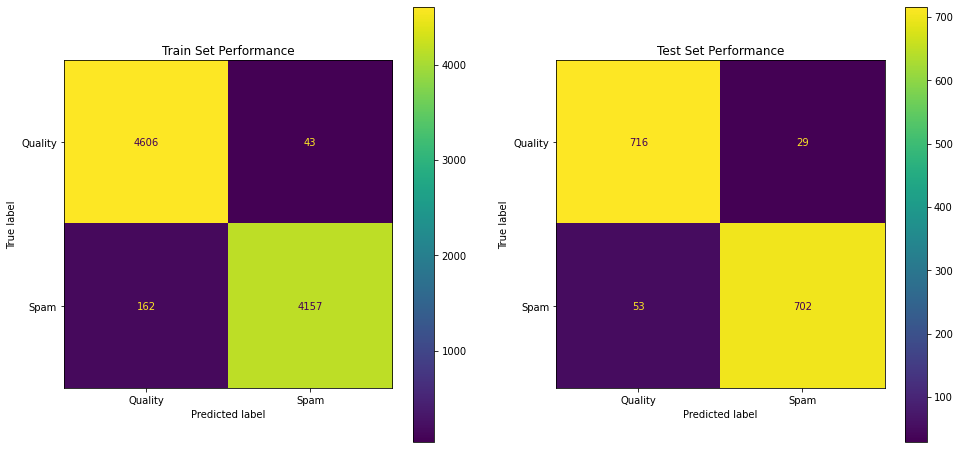

In [7]:
mnb = MultinomialNB()
mnb.set_params(**nb_params)
start_time = process_time()
mnb_fit.fit(x_train_vect, y_train)
end_time = process_time()
print(f"Training Time: {end_time - start_time:0.10f}")

fig = plt.figure(figsize=[25, 8])
for i, (x, y, k) in enumerate([(x_train_vect, y_train, 'Train'), (x_test_vect, y_test, 'Test')]): #(x_val_vect, y_val, 'Val')
    ax = fig.add_subplot(1, 3, i+1)
    conf = ConfusionMatrixDisplay.from_estimator(mnb_fit, x, y, ax=ax) #, normalize='pred'
    conf.ax_.set_title(k + ' Set Performance')
    
    start_time = process_time()
    pred = mnb_fit.predict(x)
    end_time = process_time()

    print(f"{k} Inference Time: {end_time - start_time:0.10f} s")
    print(classification_report(y, pred)) 

In [9]:
# Save predictions
savedata(mnb_fit.predict(x_test_vect), "nb_preds")